#### Notebook options

In [1]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [2]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

#### Imports

<Figure size 160x160 with 0 Axes>

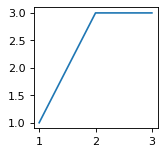

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import os
from JetEtaBins import JetEtaBins, PtBins
from helpers import read_data
# from correction_fitter_helpers import save_correction_txt_file, init_vals_2014, init_two_gaus, fit_corrections

#### some newer versions of pyplot and mplhep, aren't good friends with jupyter
#### To make the plots be formatted directly well, we need to make a dummy plot and rerun the import
### (a very silly solution)
plt.figure(num=None, figsize=(2, 2), dpi=80)
plt.plot([1,2,3],[1,3,3])
import matplotlib.pyplot as plt

In [5]:
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle(style='hep')
plt.rcParams['figure.dpi'] = 150

### Fitting the inverse median responses

### Fitting the mean responses

In [6]:
def my_mapping(flav):
    return 'a' if flav=='all' else flav

In [7]:
figdir = "fig/median_correction_fits"

if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
eta_binning  = "Summer20Flavor" #"Summer20Flavor"  ### HCalPart, JERC, CoarseCalo, CaloTowers, onebin, Summer20Flavor;
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

combine_antiflavour = True
combine_antiflavour_txt = '_split_antiflav' if not combine_antiflavour else ''

jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")

In [9]:
from fileNames.available_datasets import legend_labels
ttbarlab = legend_labels['ttbar']['lab']

In [10]:
pltStyle(style='hep')
# plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

plt.rcParams['figure.subplot.top'] = 0.93
plt.rcParams['figure.subplot.right'] = 0.96
# pltStyle(style='hep')
# plt.rcParams['figure.subplot.bottom'] = 0.37
plt.rcParams['figure.subplot.left'] = 0.16
plt.rcParams['font.size'] = plt.rcParams['font.size']/1.02

In [11]:
from collections.abc import Iterable
out_txt_path = 'out_txt'

def read_data4plot(flav, tag, closure=1, path=out_txt_path):
    '''Read the Mean, MeanStd and RecoPt values of the data with tag `tag` and flavor `flav`.
    If closure==1, there is no clusure, otherwise it has to be of the same shape as the data read '''
    mean_name = "Median" #or 'Mean'
    mean_name_std = mean_name+'Std'
    if not isinstance(closure, Iterable):
        closure_tmp = np.array([closure])
    else:
        closure_tmp = np.array(closure).copy()
        closure_tmp[closure_tmp==0] = np.nan
    median = read_data(mean_name, flav, tag, path)/closure_tmp #[2:]
    median[(median==0) | (np.abs(median)==np.inf)] = np.nan
    medianstd = read_data(mean_name_std, flav, tag, path) #[2:]
    reco = read_data("MeanRecoPt", flav, tag, path)
    median = 1/median
    medianstd = median**2*medianstd
    return [median, medianstd, reco]

In [12]:
import correction_fitter_helpers as fits

### Individual fits

In [13]:
fits2plot = { ##name: [function, initial values, # parameters]
             "MC truth": [fits.response_fnc, [0]*6, 6],
             "MC truth extended": [fits.two_gaus_fnc, [0]*9, 9],
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
             "Poly, n=3": [fits.poly3, [ 1, 1, 1, 1], 4],
             }

In [45]:
if not combine_antiflavour:
    flavors = ['bbar', 'b', 'c', 's', 'ud', 'q', 'cbar', 'sbar', 'udbar', 'qbar']
else:
    flavors = ['b', 'c', 'u', 'd', 'g', 's', 'ud', 'q', 'all']
# flavors = ['b', 'c', 'g', 's', 'ud', 'all', 'unmatched']
# flavors = ['b']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
# min_rel_uncert = 0.0005
min_rel_uncert_relative = 0.05
# tags = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR']
# tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7"]
# tags, names = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8"]
# tags, names = ['_L5_Pythia-TTBAR', '_L5_QCD-MG-Py'], [f"{ttbarlab} Pow+Py8", 'QCD, MG+Py8']
tags, names = ['_L5_QCD-Py'], ['QCD, Py8']
# tags = ['_L5_Pythia-TTBAR']
tags = [tag+eta_binning_str+combine_antiflavour_txt for tag in tags]

# tags = ['_L5_QCD-MG-Her_fineeta', '_L5_Herwig-TTBAR_fineeta']
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{combine_antiflavour_txt}_Her{eta_binning_str}.txt'
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{combine_antiflavour_txt+eta_binning_str}.txt'
txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePy{combine_antiflavour_txt}QCD{eta_binning_str}.txt'
# txtfile_outname = f''

# tag_full = '_L5_TTBAR-JME'
# tag_full = '_L5_QCD-MG-Her'
# tag_full = '_L5_QCD-MG-Py'

# closure = read_data("Median", "all", '_L5_QCD-MG-Py'+eta_binning_str)
closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMedian_all_L5_QCD-JME-etaAut18'+'.csv').set_index('etaBins')
# closure = df_csv.to_numpy().transpose()
# closure = read_data("Median", 'all')

fit_res_all_tags = {}
for data_tag, data_name in np.transpose([tags, names]):
    fit_res_all = {}
    
    for flav in flavors:
        fit_res = []
        data = read_data("Median", flav, data_tag)
        data[data==0] = np.nan
        mean = (1/data)
        if not combine_antiflavour:
            flav2 = flav[:-3] if 'bar' in flav else flav
            closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
        data = {data_tag: read_data4plot(flav, data_tag, closure )}

        for etaidx in range(jeteta_bins.nbins):
            print('Fitting subsample: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                                                 fits2plot=fits2plot, main_fit="Poly, n=3",
                              figdir2=figdir,
                              jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                              plot_initial_val=False,
                              use_recopt=True,
                              maxlimit_static_pnt=True,
#                               max_ptval=4000,
                              min_rel_uncert_relative=min_rel_uncert_relative,
                              show_original_errorbars=True)
            
            fit_res = np.concatenate([fit_res, fit_res_new])

        num = int(5 + fit_res[2])
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
        correction_name = my_mapping(flav)
        correction_name += 'T' if 'TTBAR' in data_tag else 'J' 
        fit_res_all[correction_name] = fit_res
    fit_res_all_tags[data_tag] = fit_res_all

'a';

Fitting subsample:  b Eta idx = 0, eta bin = [0.0; 1.305 ]
No points to fit. Returning a unity function.
Fitting subsample:  b Eta idx = 1, eta bin = [1.305; 2.5 ]
No points to fit. Returning a unity function.
Fitting subsample:  b Eta idx = 2, eta bin = [2.5; 3.139 ]
No points to fit. Returning a unity function.
Fitting subsample:  b Eta idx = 3, eta bin = [3.139; 5.191 ]
No points to fit. Returning a unity function.
Fitting subsample:  c Eta idx = 0, eta bin = [0.0; 1.305 ]
No points to fit. Returning a unity function.
Fitting subsample:  c Eta idx = 1, eta bin = [1.305; 2.5 ]
No points to fit. Returning a unity function.
Fitting subsample:  c Eta idx = 2, eta bin = [2.5; 3.139 ]
No points to fit. Returning a unity function.
Fitting subsample:  c Eta idx = 3, eta bin = [3.139; 5.191 ]
No points to fit. Returning a unity function.
Fitting subsample:  u Eta idx = 0, eta bin = [0.0; 1.305 ]
No points to fit. Returning a unity function.
Fitting subsample:  u Eta idx = 1, eta bin = [1.305

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:234: RuntimeWarning: All-NaN slice encountered
  min_rel_uncert_tmp = min_rel_uncert_relative*(np.nanmax(yvals)-np.nanmin(yvals))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:234: RuntimeWarning: All-NaN slice encountered
  min_rel_uncert_tmp = min_rel_uncert_relative*(np.nanmax(yvals)-np.nanmin(yvals))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:234: RuntimeWarning: All-NaN slice encountered
  min_rel_uncert_tmp = min_rel_uncert_relative*(np.nanmax(yvals)-np.nanmin(yvals))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:234: RuntimeWarning: All-NaN slice encountered
  min_rel_uncert_tmp = min_rel_uncert_relative*(np.nanmax(yvals)-np.nanmin(yvals))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:234: RuntimeWarning: All-NaN slice encountered
  min_rel_uncert_tmp = min_rel_uncert_relative*(

In [46]:
# txtfile_outname = 'test.txt'
fits.save_correction_txt_file(txtfile_outname, fit_res_all_tags)

Saving the corrections with the name =  Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD.txt


In [47]:
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                
# print("Saving the corrections with the name = ", txtfile_outname)

In [48]:
# # txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                

# 4; ## to suppress printouts of write

### Combined fit

Fitting flavor:  b Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta0p0to0p261.pdf / .png


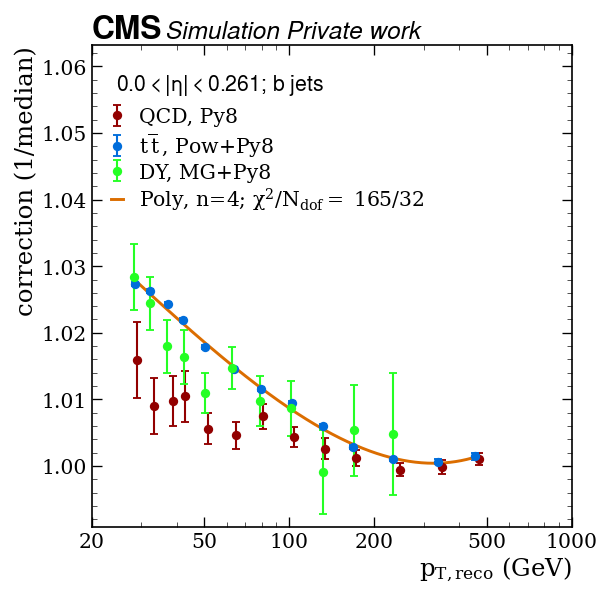

Fitting flavor:  b Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta0p261to0p522.pdf / .png


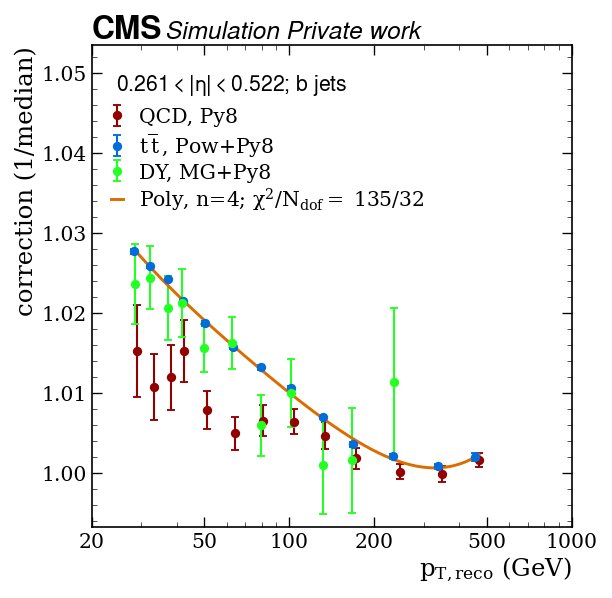

Fitting flavor:  b Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta0p522to0p783.pdf / .png


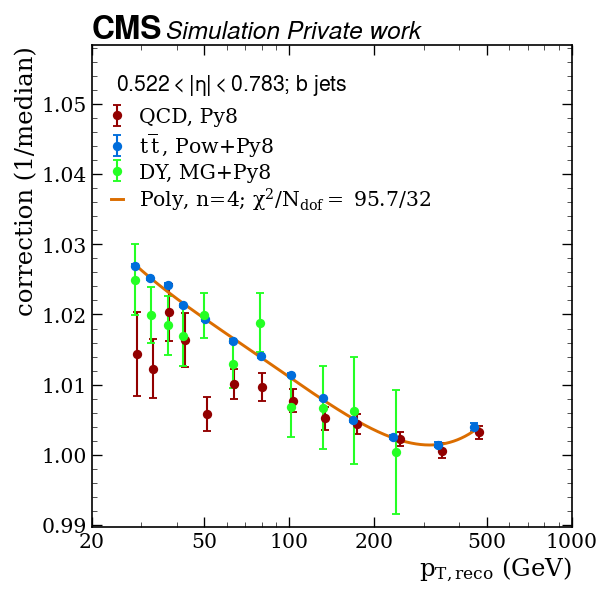

Fitting flavor:  b Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta0p783to1p044.pdf / .png


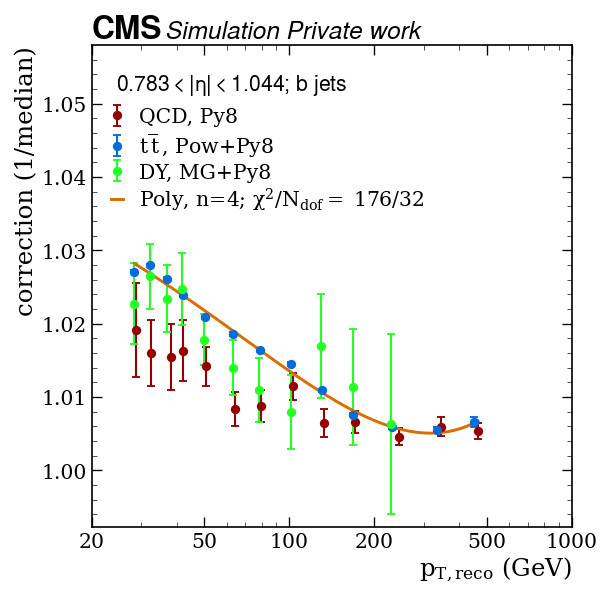

Fitting flavor:  b Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p044to1p305.pdf / .png


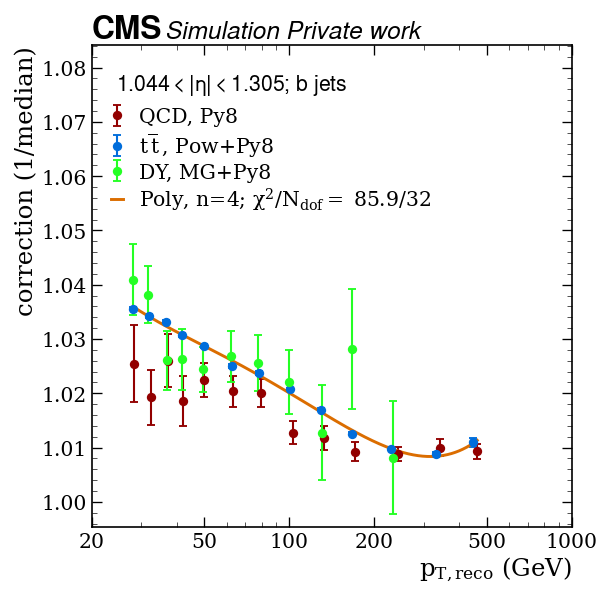

Fitting flavor:  b Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p305to1p566.pdf / .png


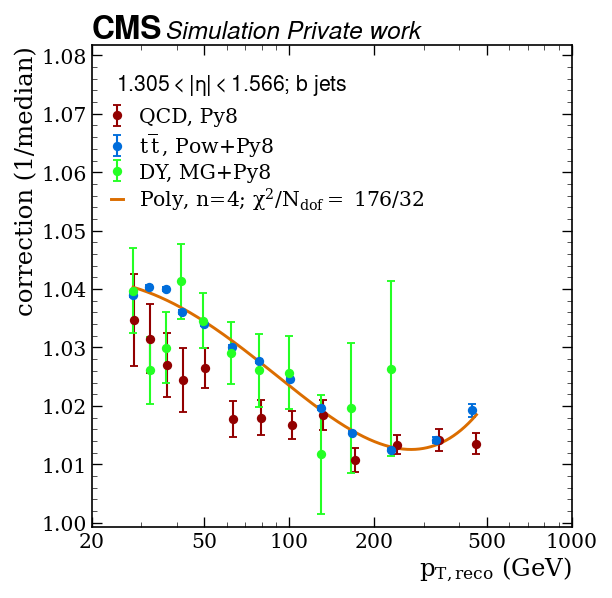

Fitting flavor:  b Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p566to1p74.pdf / .png


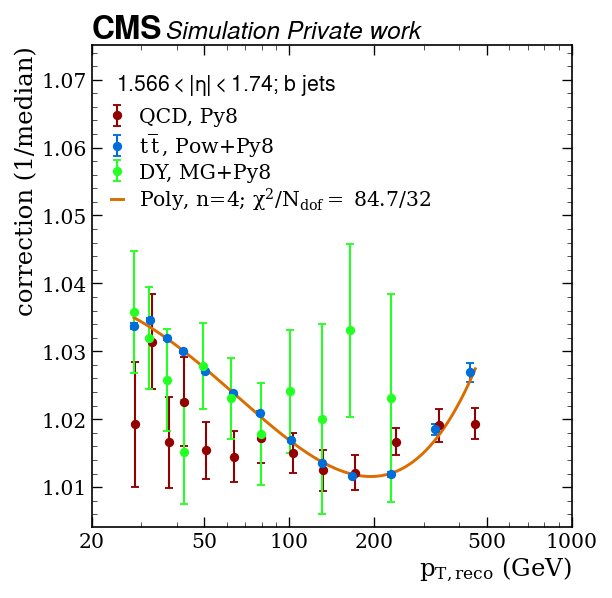

Fitting flavor:  b Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p74to1p93.pdf / .png


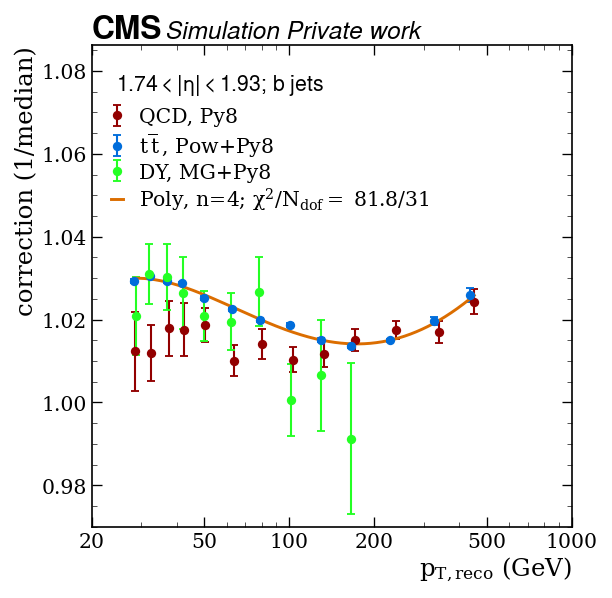

Fitting flavor:  b Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p93to2p043.pdf / .png


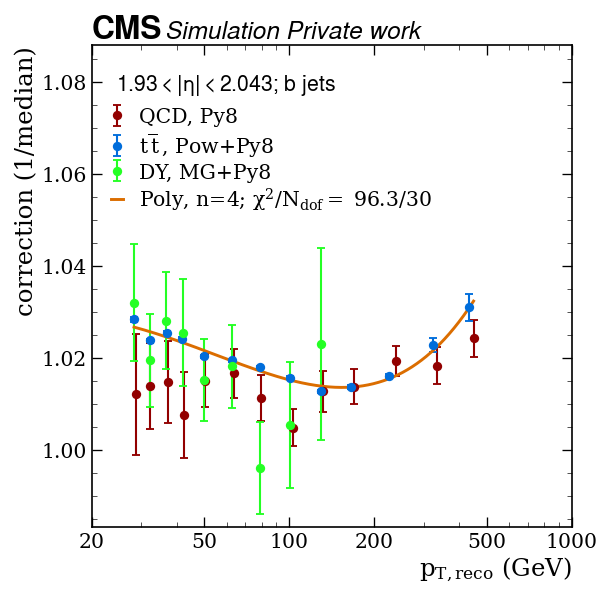

Fitting flavor:  b Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta2p043to2p172.pdf / .png


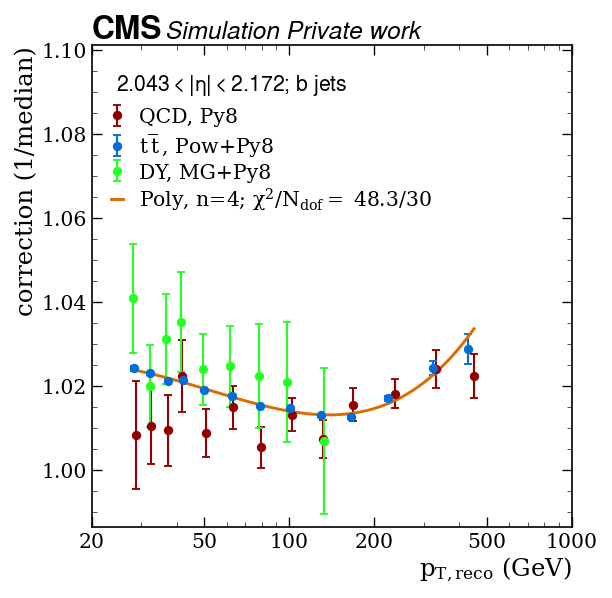

Fitting flavor:  b Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta2p172to2p5.pdf / .png


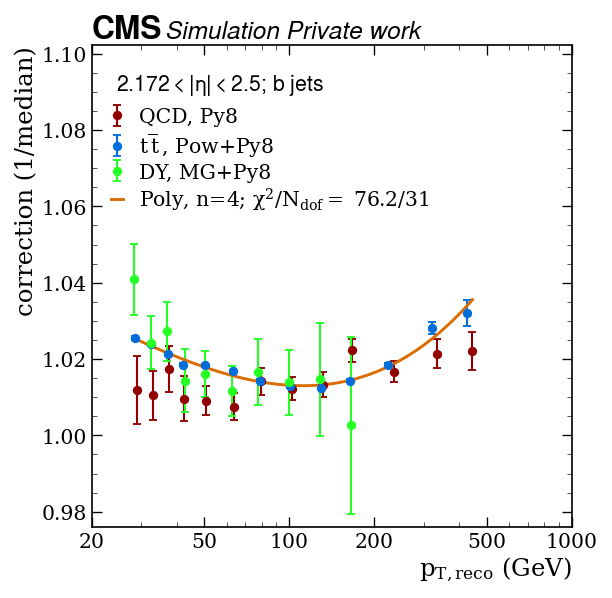

Fitting flavor:  b Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta2p5to2p964.pdf / .png


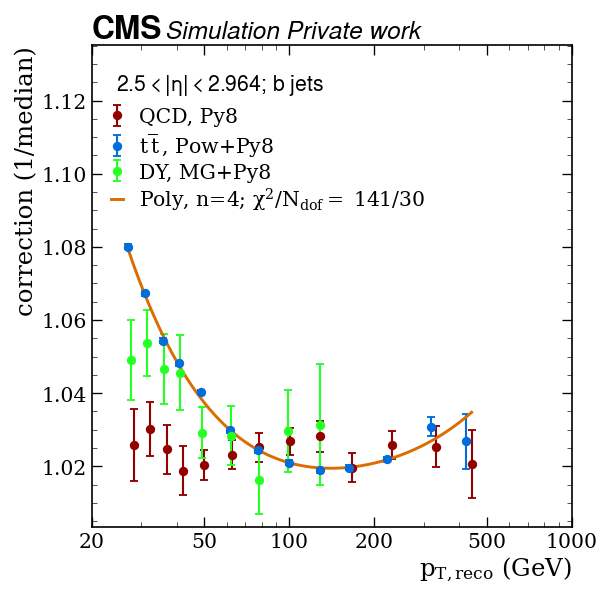

Fitting flavor:  b Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta2p964to5p191.pdf / .png


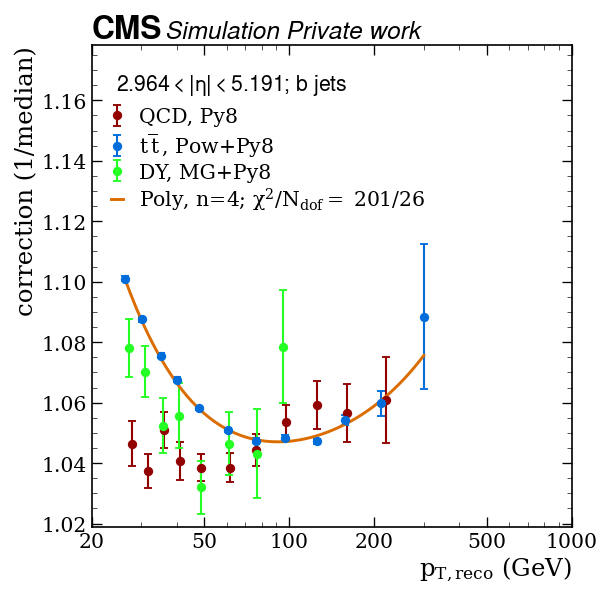

Fitting flavor:  c Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta0p0to0p261.pdf / .png


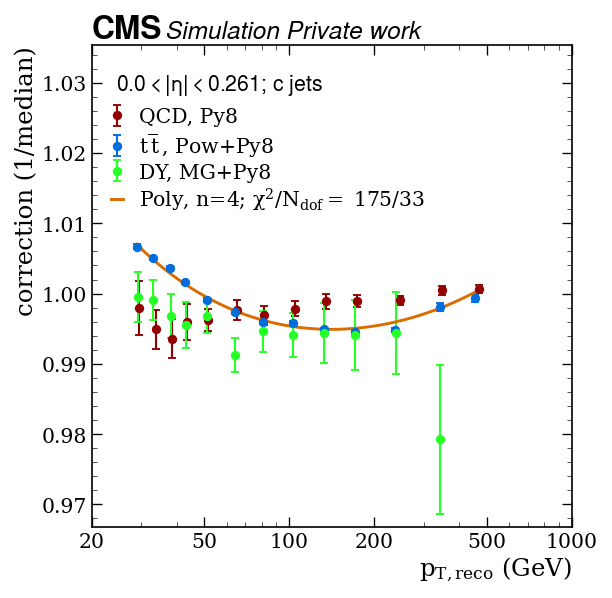

Fitting flavor:  c Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta0p261to0p522.pdf / .png


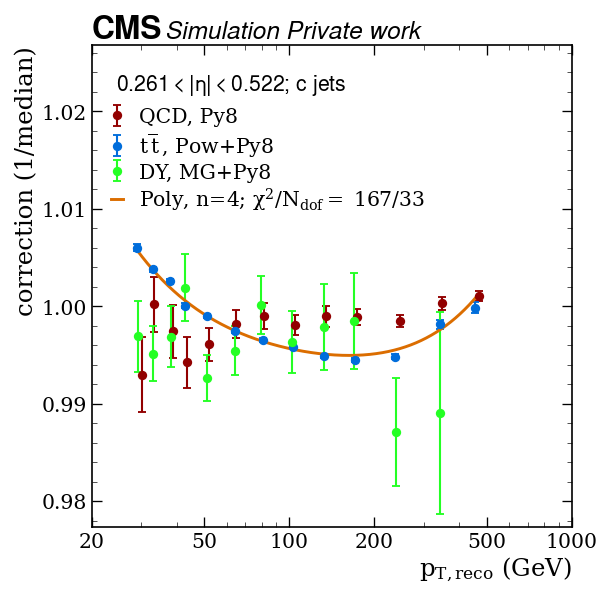

Fitting flavor:  c Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta0p522to0p783.pdf / .png


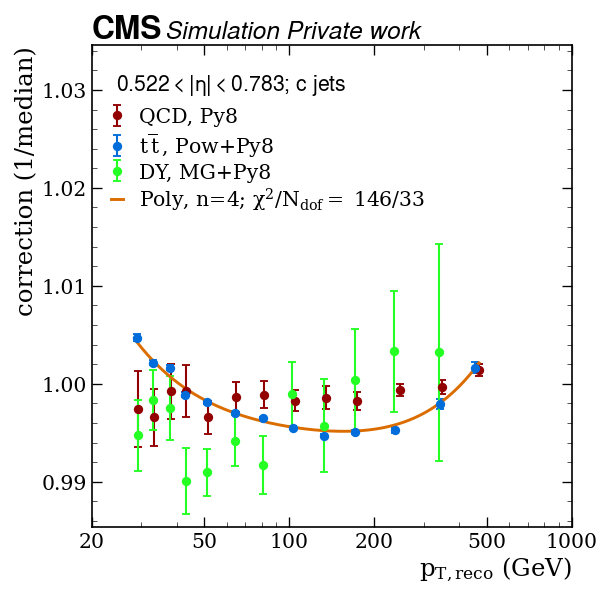

Fitting flavor:  c Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta0p783to1p044.pdf / .png


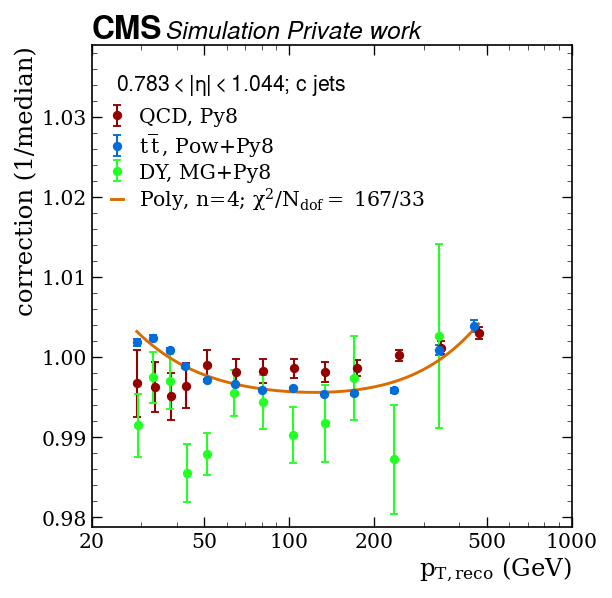

Fitting flavor:  c Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p044to1p305.pdf / .png


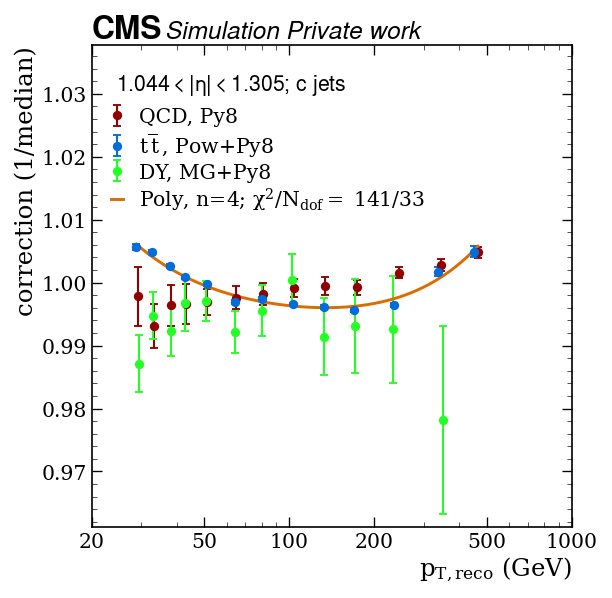

Fitting flavor:  c Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p305to1p566.pdf / .png


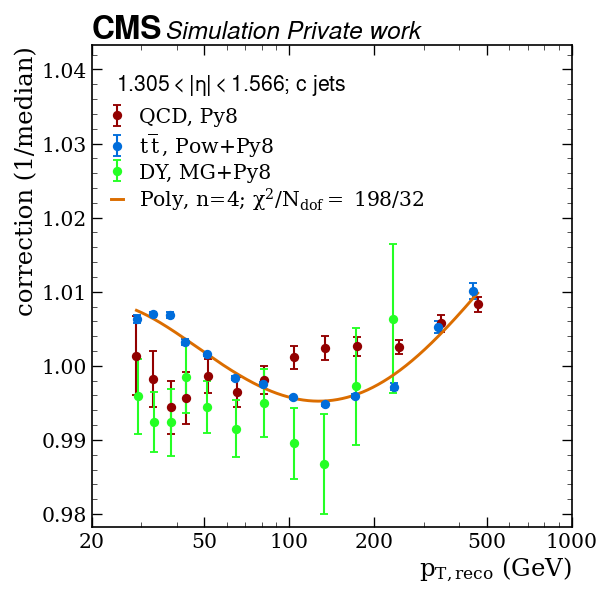

Fitting flavor:  c Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p566to1p74.pdf / .png


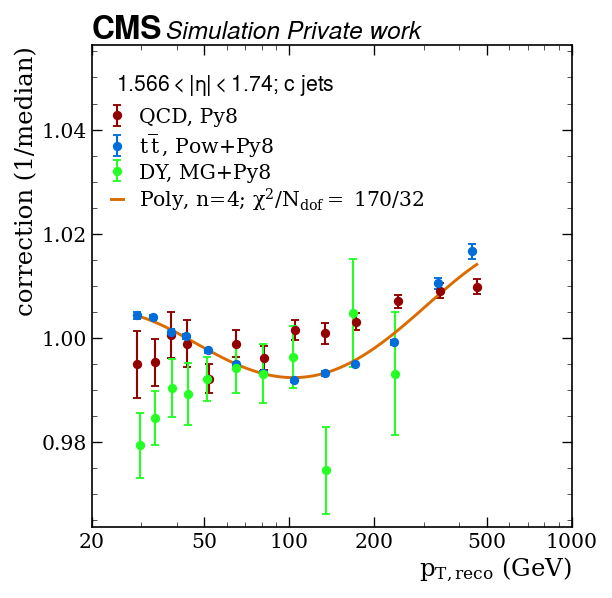

Fitting flavor:  c Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p74to1p93.pdf / .png


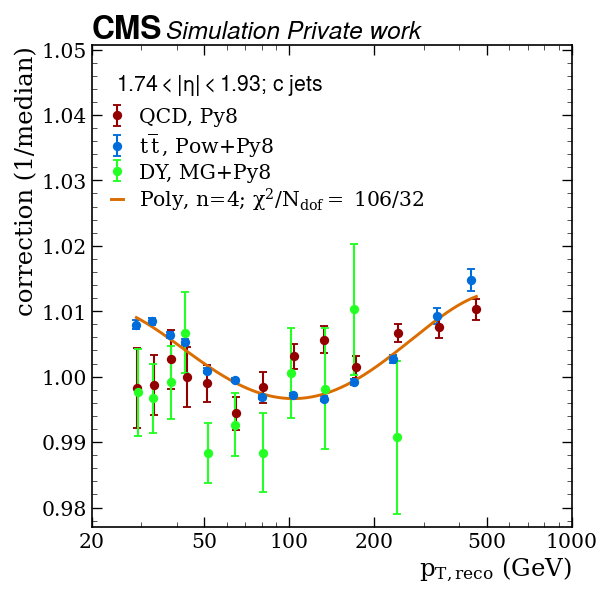

Fitting flavor:  c Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p93to2p043.pdf / .png


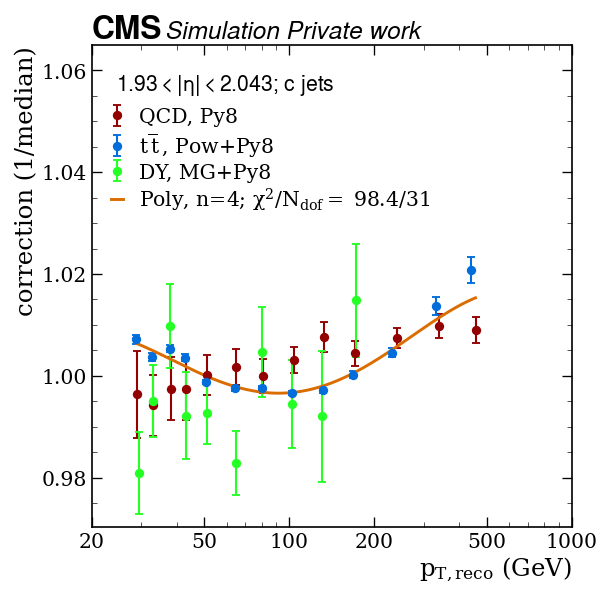

Fitting flavor:  c Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta2p043to2p172.pdf / .png


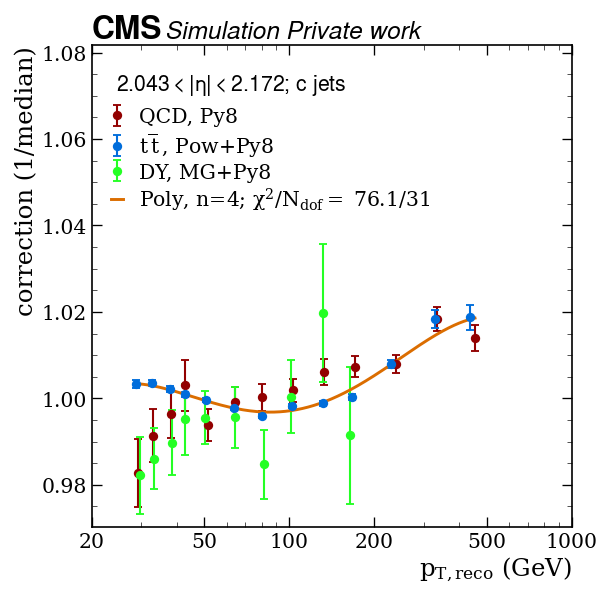

Fitting flavor:  c Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta2p172to2p5.pdf / .png


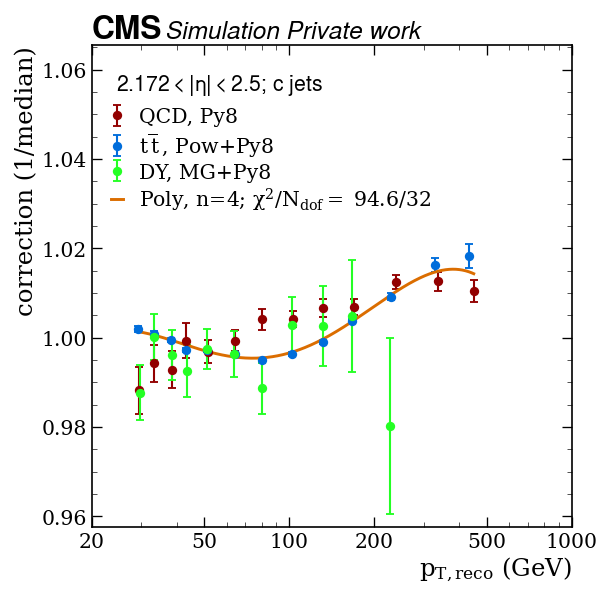

Fitting flavor:  c Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta2p5to2p964.pdf / .png


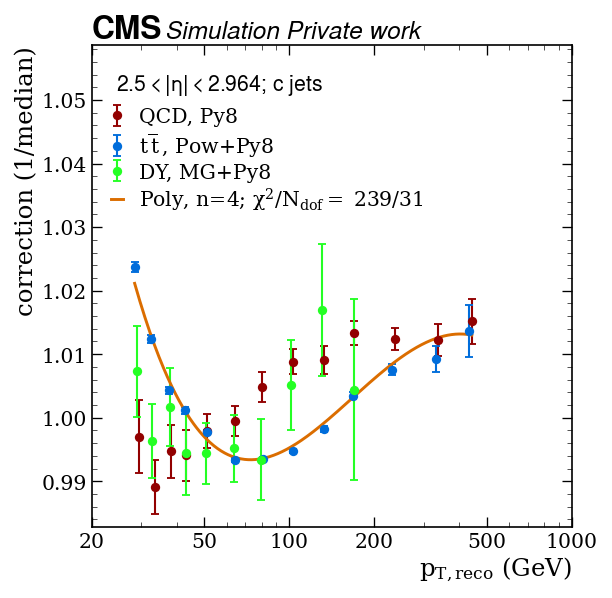

Fitting flavor:  c Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta2p964to5p191.pdf / .png


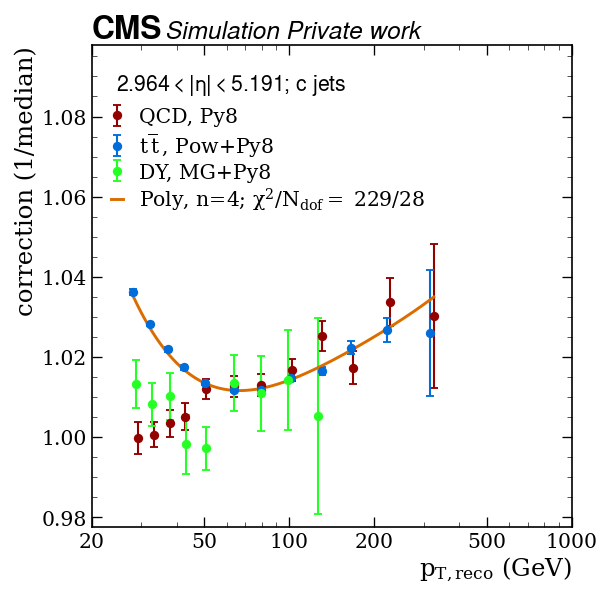

Fitting flavor:  u Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta0p0to0p261.pdf / .png


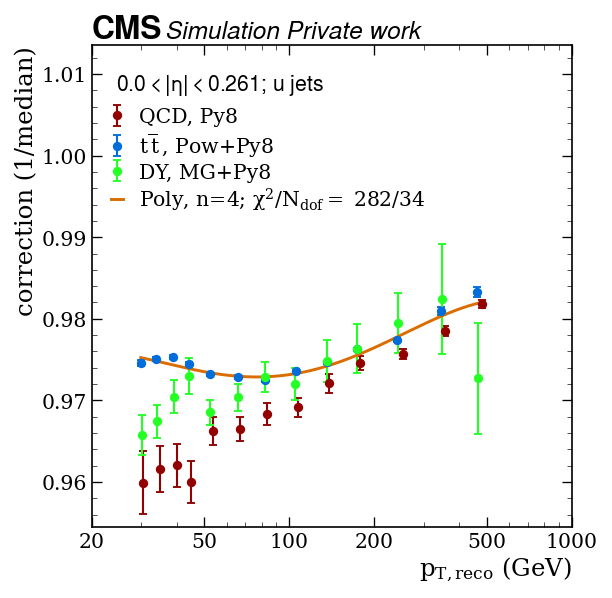

Fitting flavor:  u Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta0p261to0p522.pdf / .png


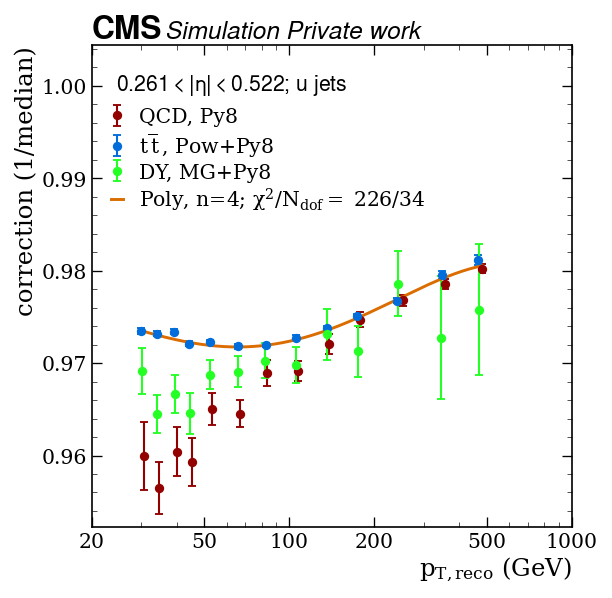

Fitting flavor:  u Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta0p522to0p783.pdf / .png


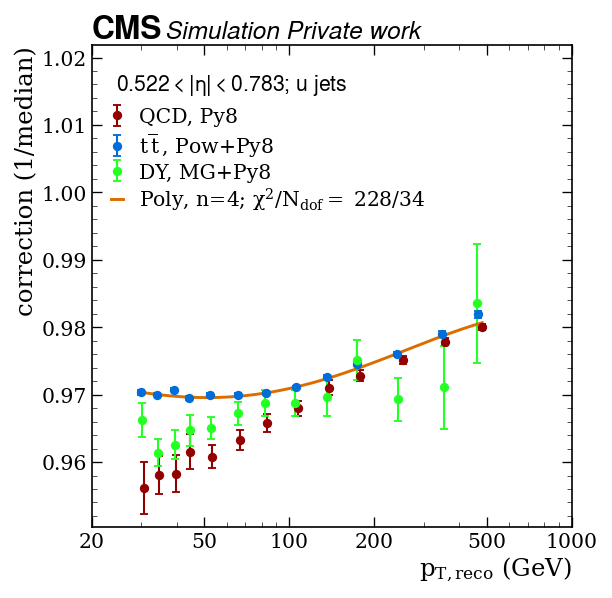

Fitting flavor:  u Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta0p783to1p044.pdf / .png


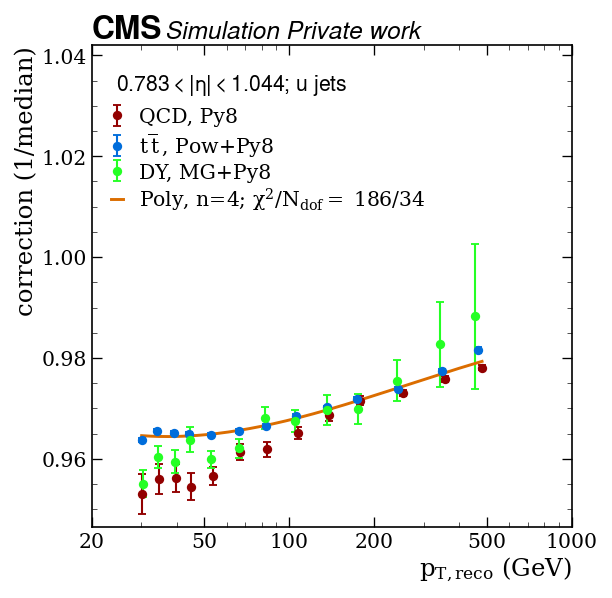

Fitting flavor:  u Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p044to1p305.pdf / .png


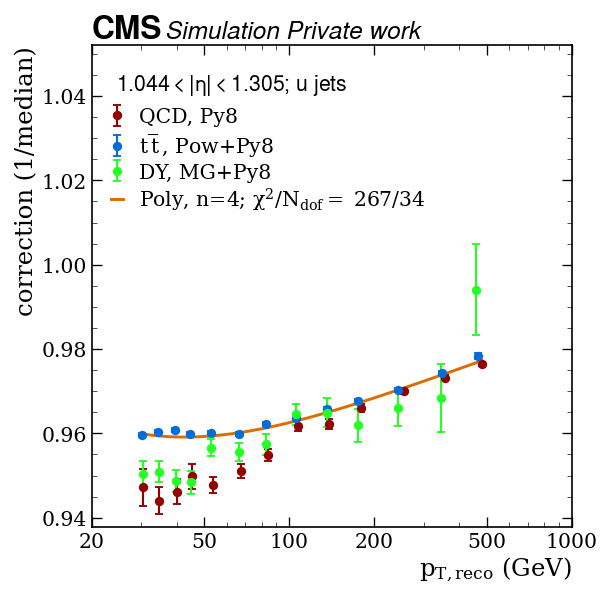

Fitting flavor:  u Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p305to1p566.pdf / .png


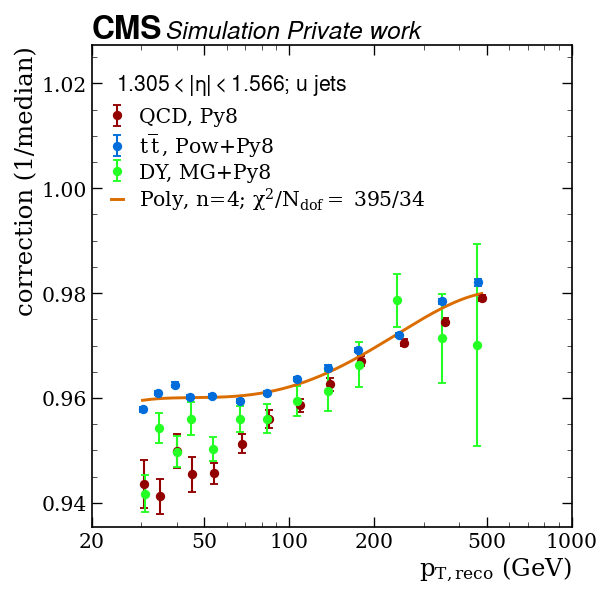

Fitting flavor:  u Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p566to1p74.pdf / .png


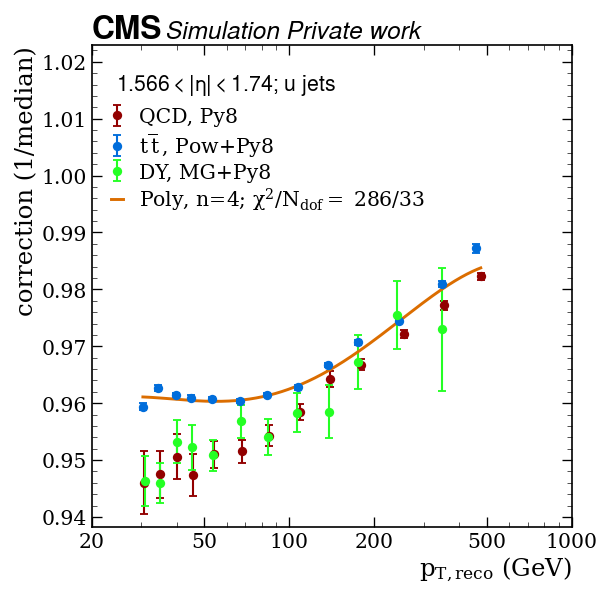

Fitting flavor:  u Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p74to1p93.pdf / .png


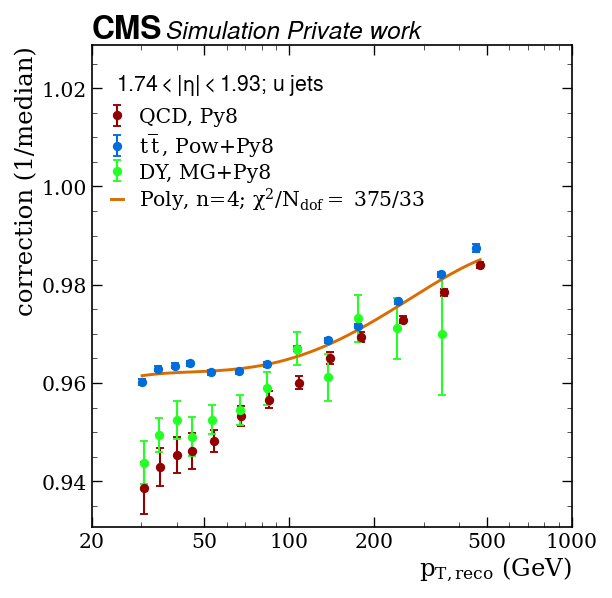

Fitting flavor:  u Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p93to2p043.pdf / .png


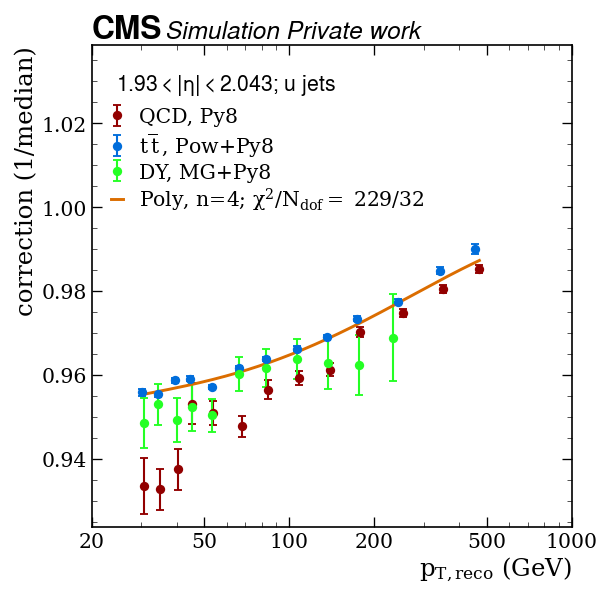

Fitting flavor:  u Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta2p043to2p172.pdf / .png


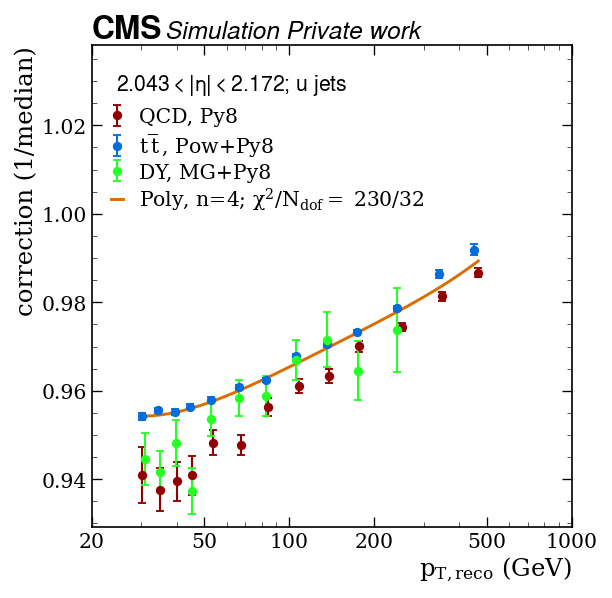

Fitting flavor:  u Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta2p172to2p5.pdf / .png


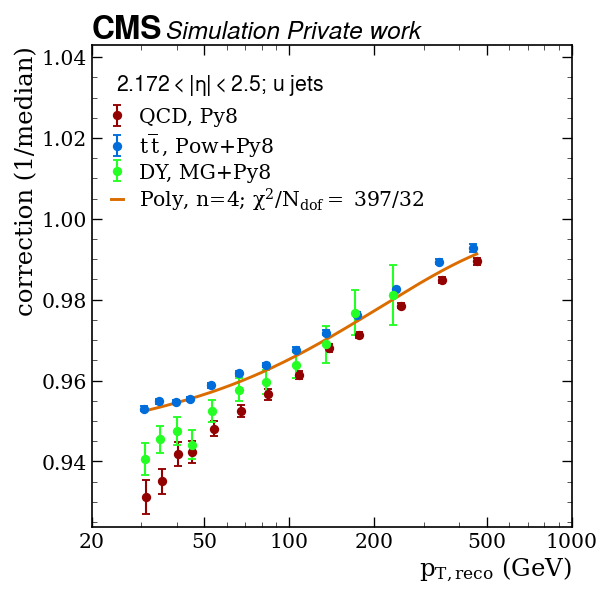

Fitting flavor:  u Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta2p5to2p964.pdf / .png


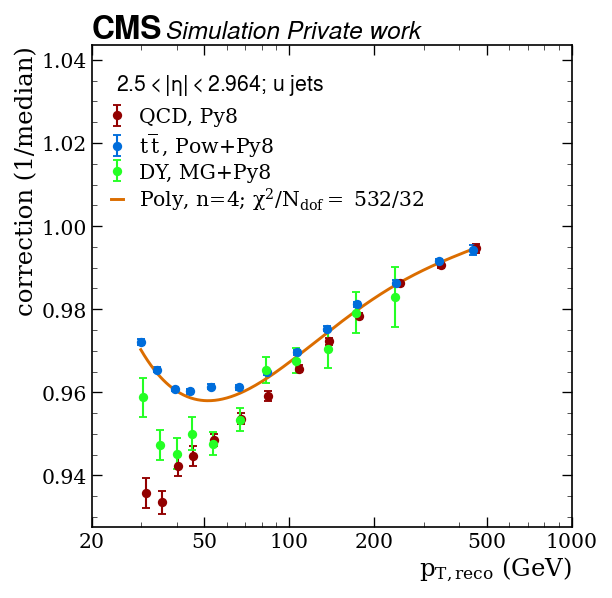

Fitting flavor:  u Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta2p964to5p191.pdf / .png


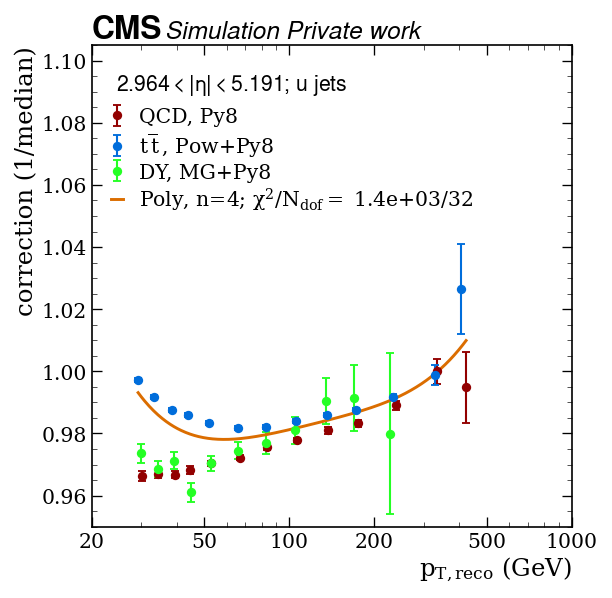

Fitting flavor:  d Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta0p0to0p261.pdf / .png


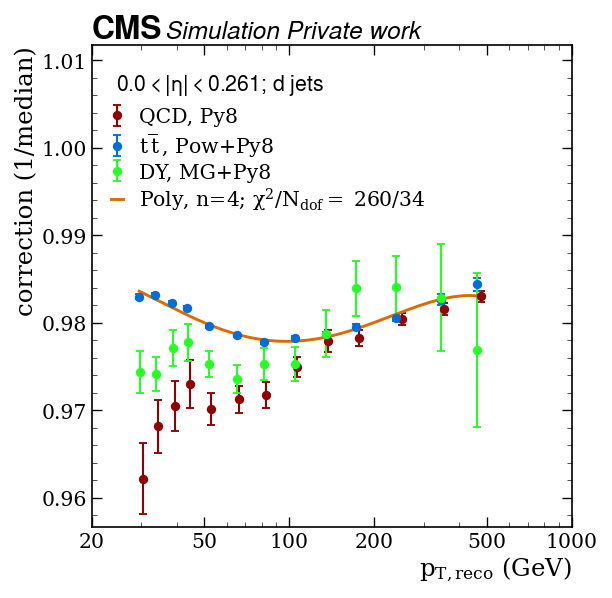

Fitting flavor:  d Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta0p261to0p522.pdf / .png


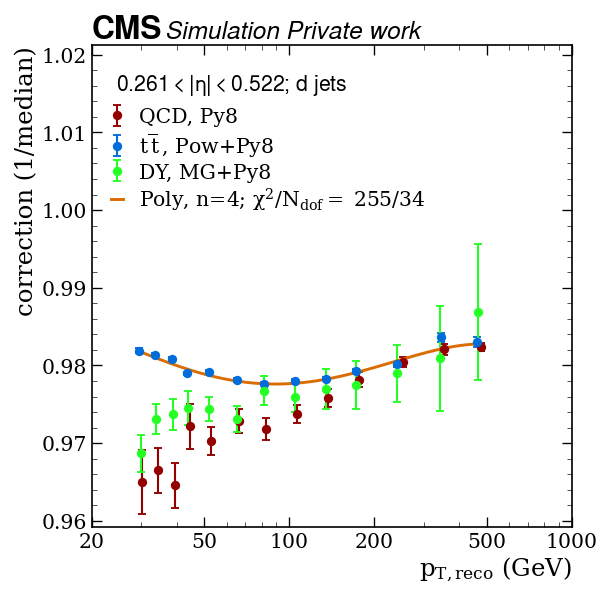

Fitting flavor:  d Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta0p522to0p783.pdf / .png


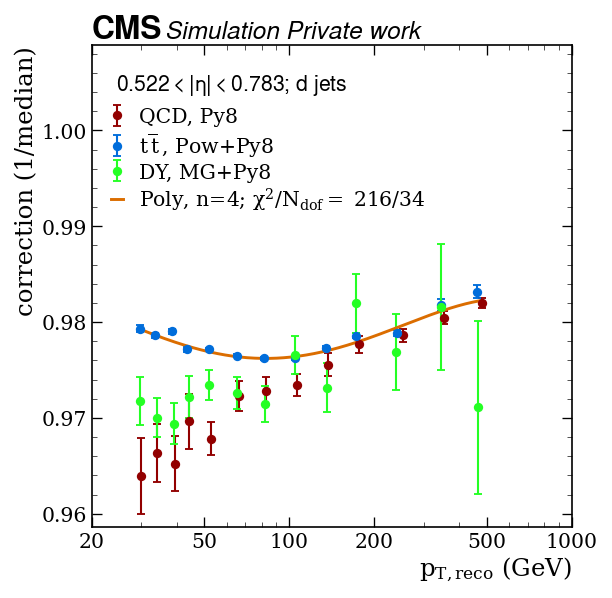

Fitting flavor:  d Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta0p783to1p044.pdf / .png


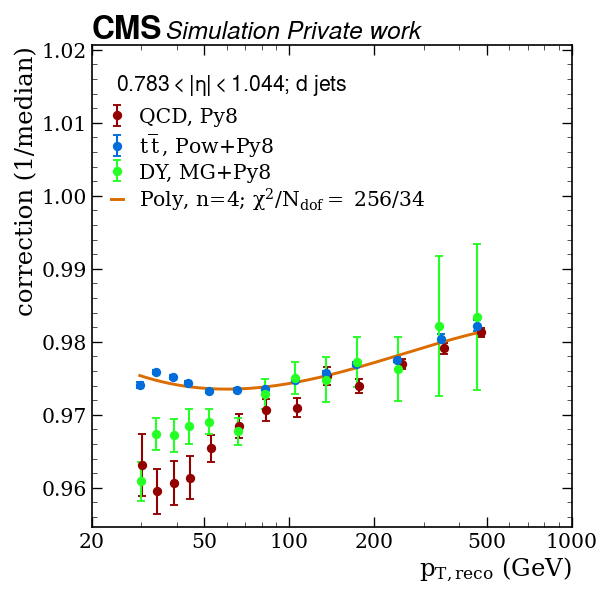

Fitting flavor:  d Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p044to1p305.pdf / .png


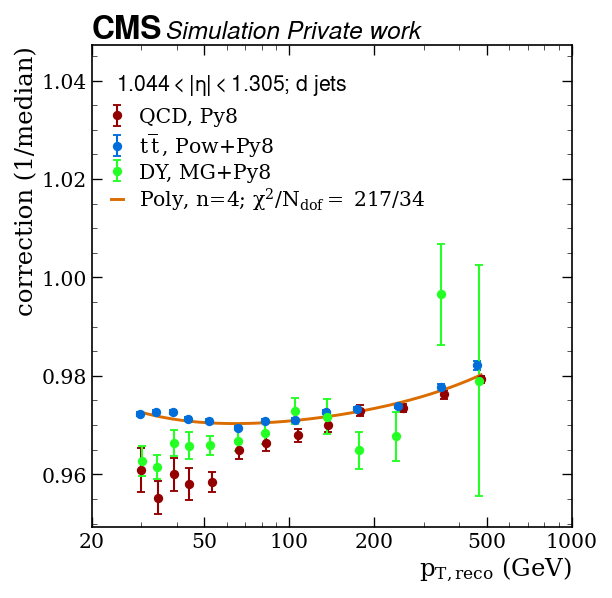

Fitting flavor:  d Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p305to1p566.pdf / .png


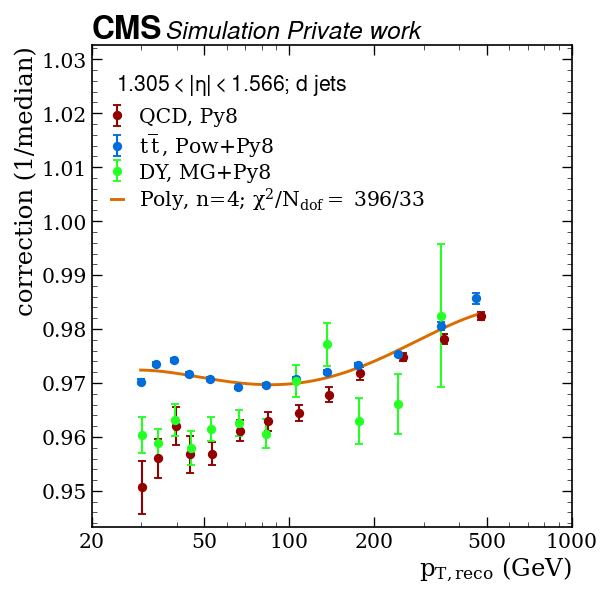

Fitting flavor:  d Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p566to1p74.pdf / .png


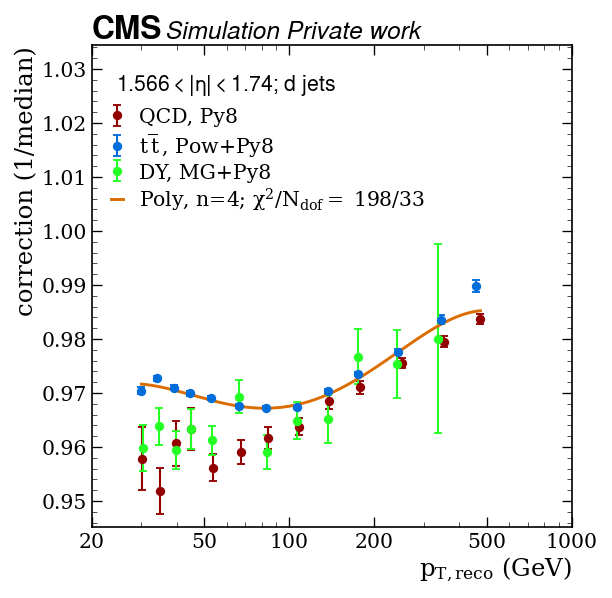

Fitting flavor:  d Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p74to1p93.pdf / .png


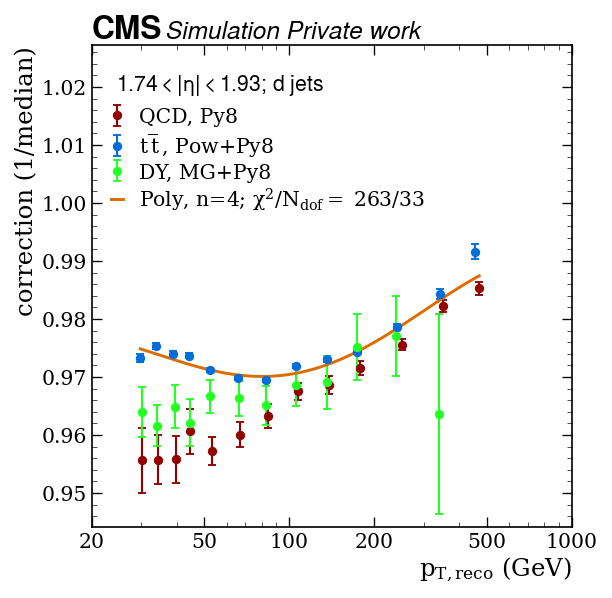

Fitting flavor:  d Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p93to2p043.pdf / .png


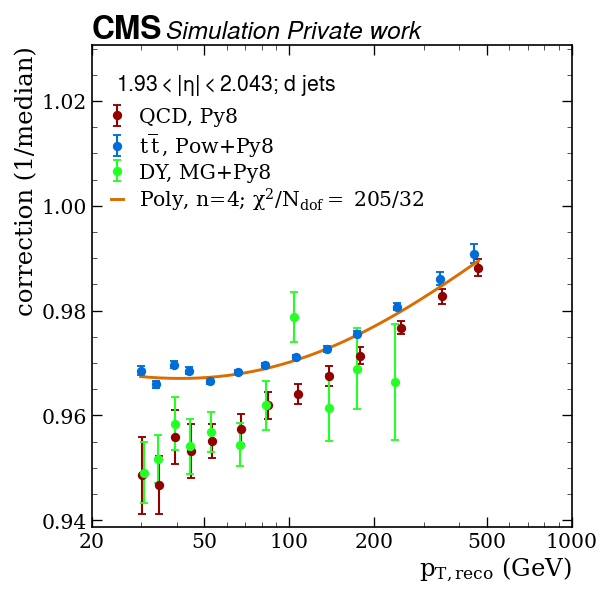

Fitting flavor:  d Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta2p043to2p172.pdf / .png


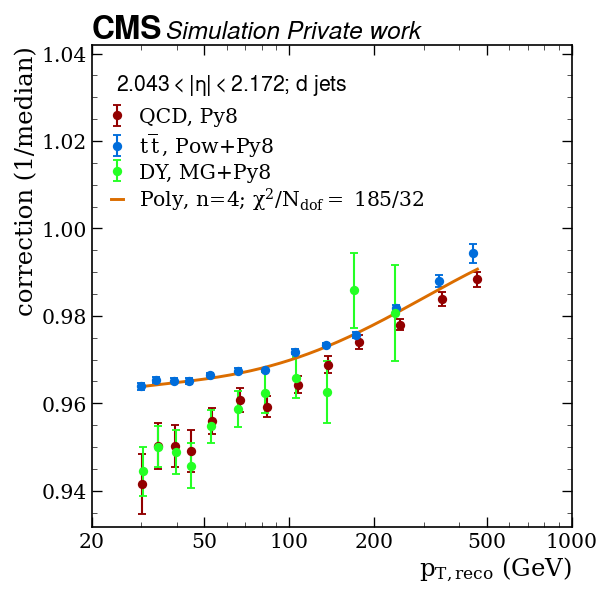

Fitting flavor:  d Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta2p172to2p5.pdf / .png


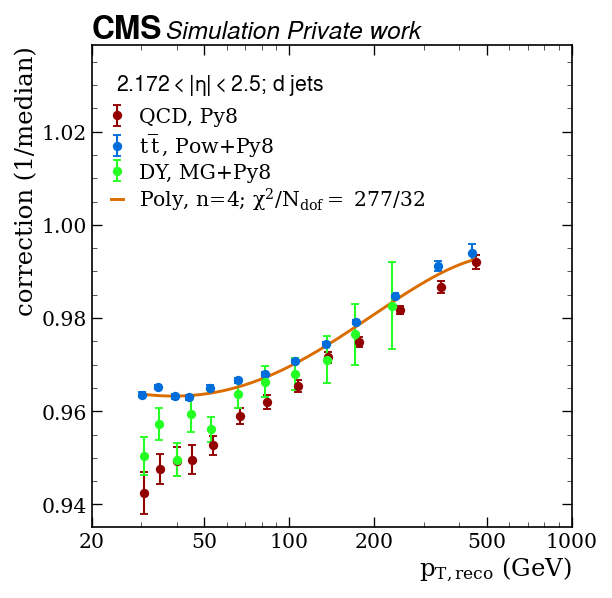

Fitting flavor:  d Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta2p5to2p964.pdf / .png


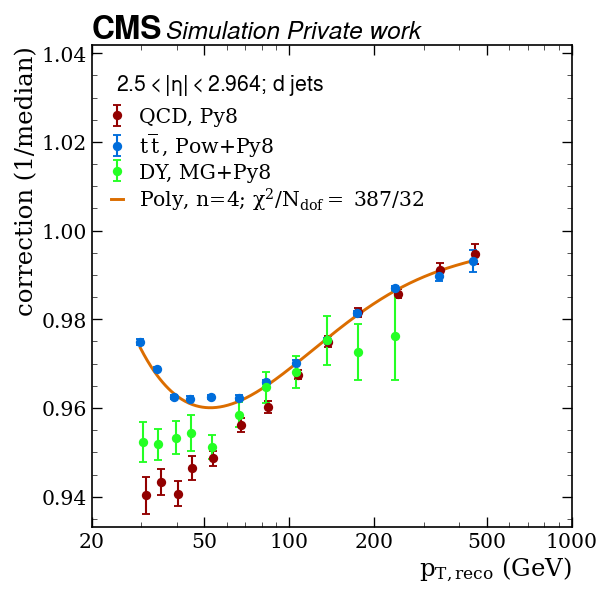

Fitting flavor:  d Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta2p964to5p191.pdf / .png


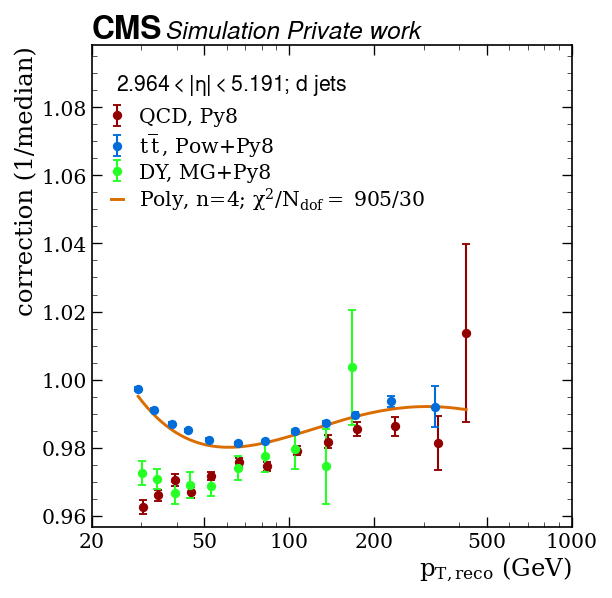

Fitting flavor:  g Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta0p0to0p261.pdf / .png


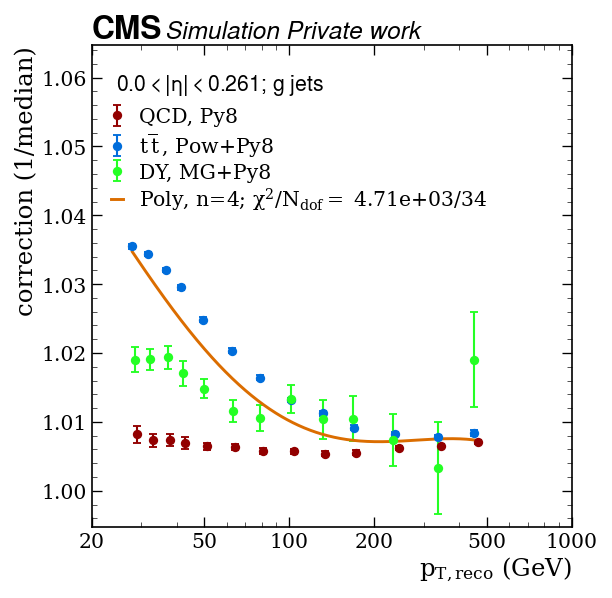

Fitting flavor:  g Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta0p261to0p522.pdf / .png


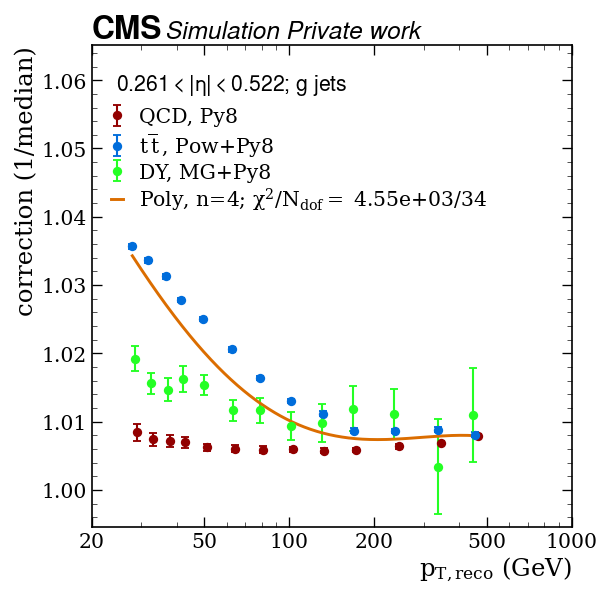

Fitting flavor:  g Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta0p522to0p783.pdf / .png


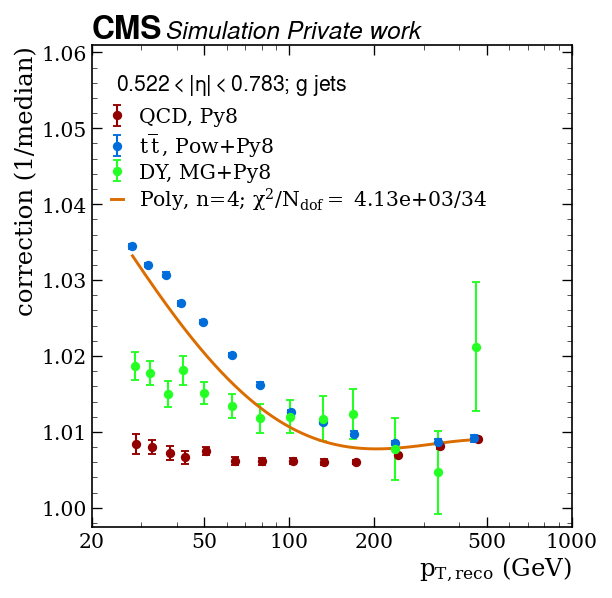

Fitting flavor:  g Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta0p783to1p044.pdf / .png


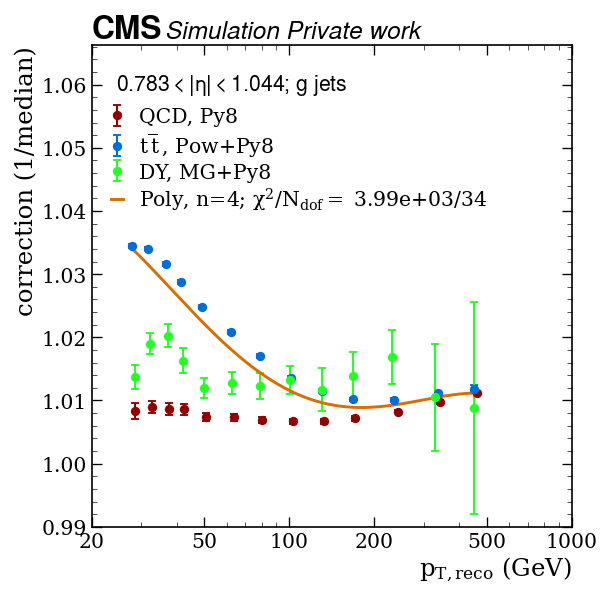

Fitting flavor:  g Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p044to1p305.pdf / .png


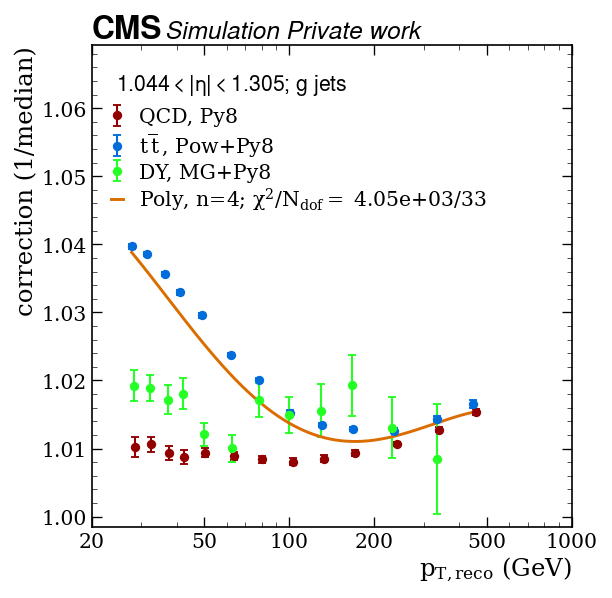

Fitting flavor:  g Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p305to1p566.pdf / .png


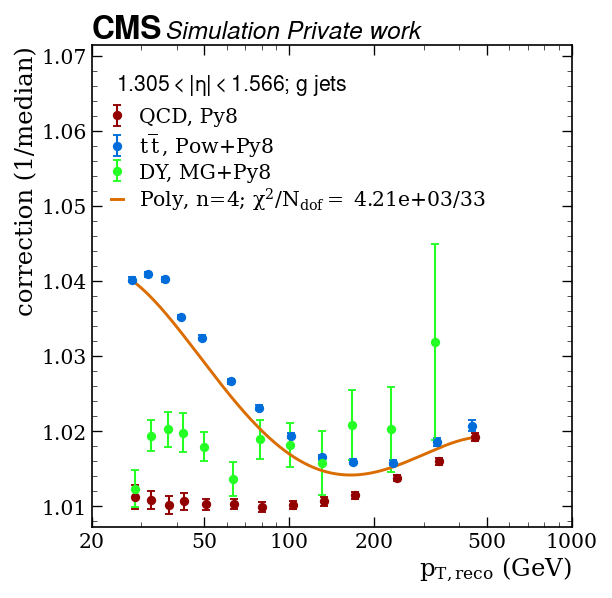

Fitting flavor:  g Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p566to1p74.pdf / .png


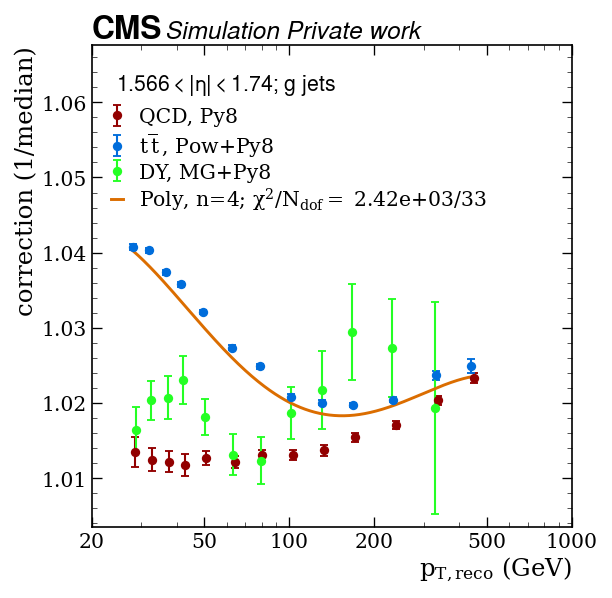

Fitting flavor:  g Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p74to1p93.pdf / .png


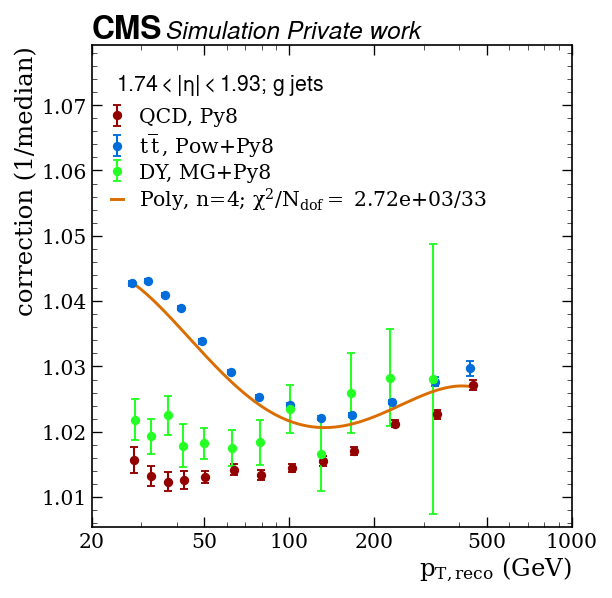

Fitting flavor:  g Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p93to2p043.pdf / .png


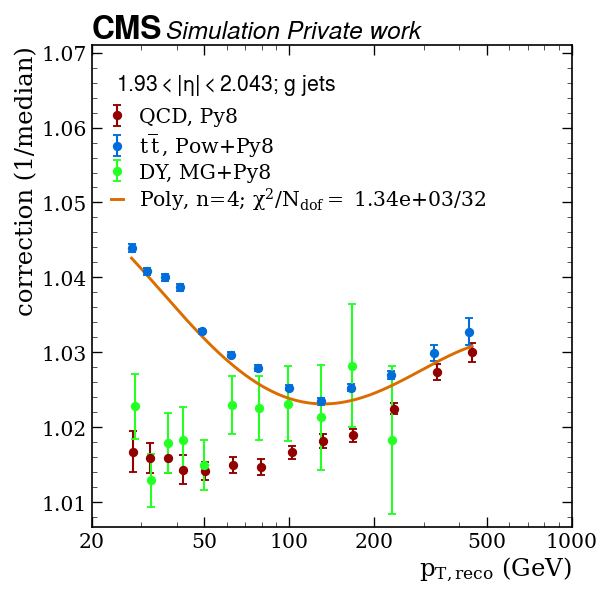

Fitting flavor:  g Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta2p043to2p172.pdf / .png


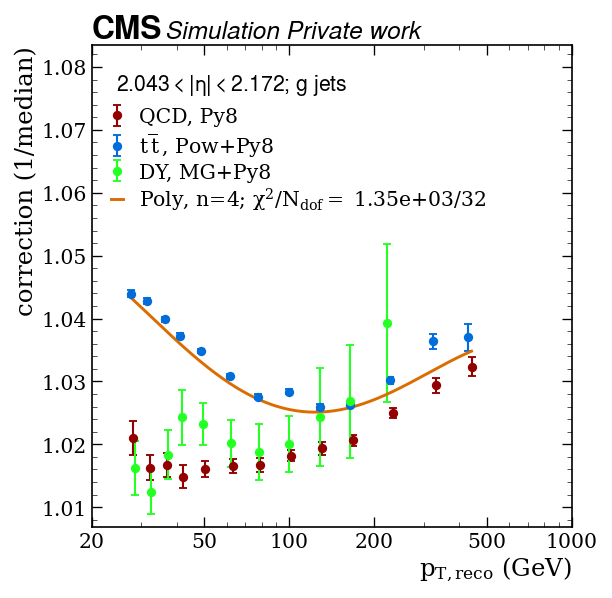

Fitting flavor:  g Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta2p172to2p5.pdf / .png


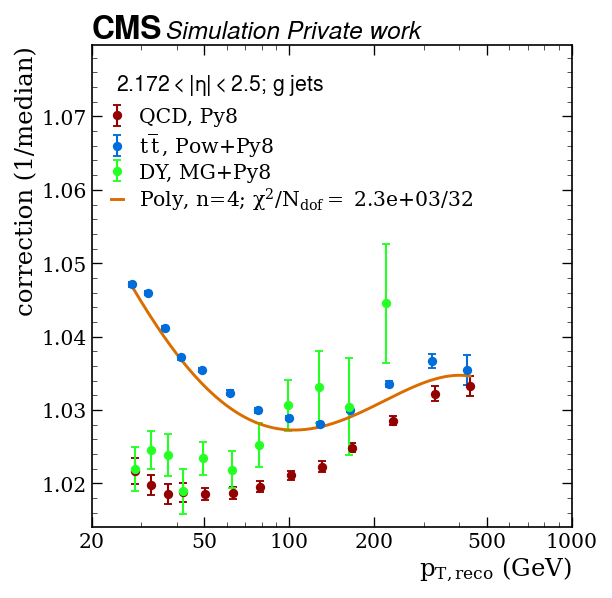

Fitting flavor:  g Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta2p5to2p964.pdf / .png


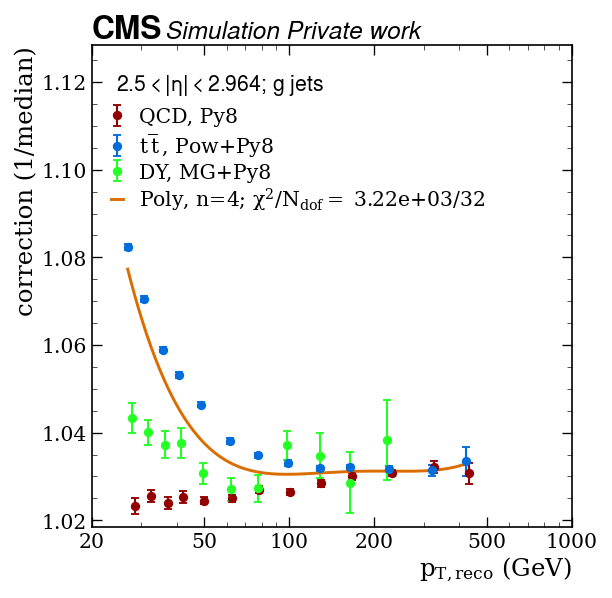

Fitting flavor:  g Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta2p964to5p191.pdf / .png


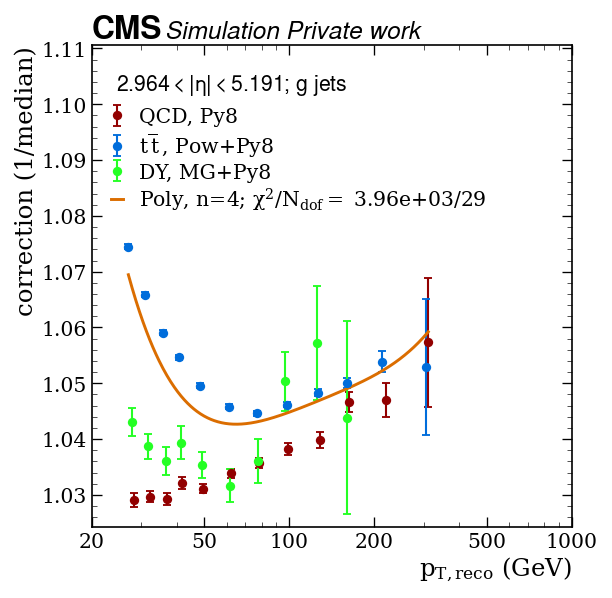

Fitting flavor:  s Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta0p0to0p261.pdf / .png


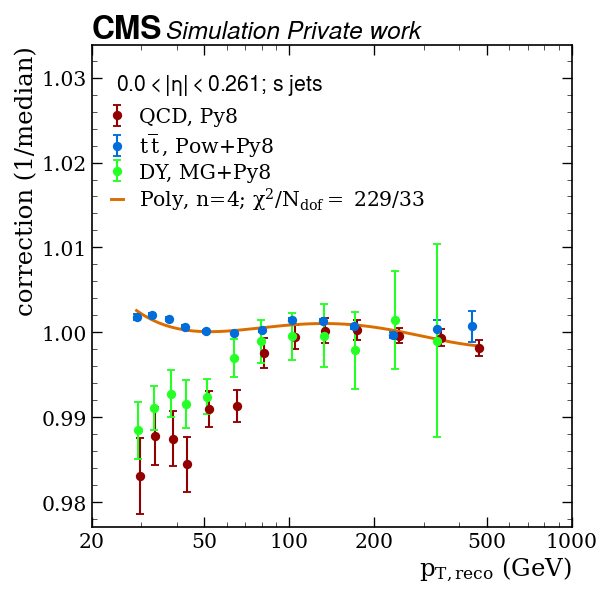

Fitting flavor:  s Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta0p261to0p522.pdf / .png


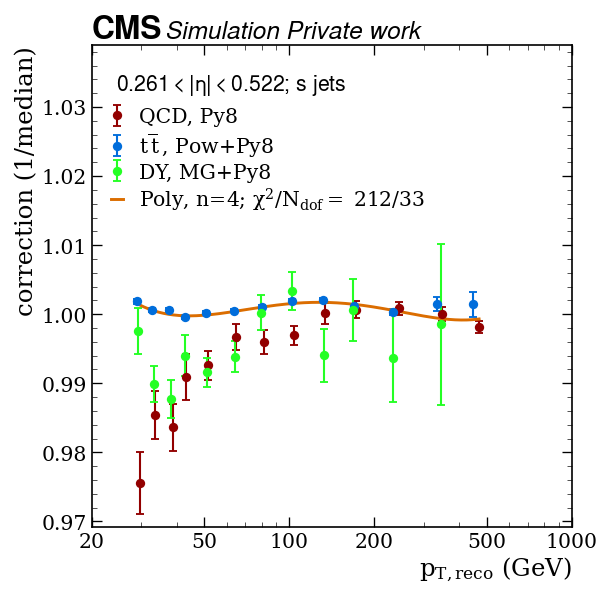

Fitting flavor:  s Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta0p522to0p783.pdf / .png


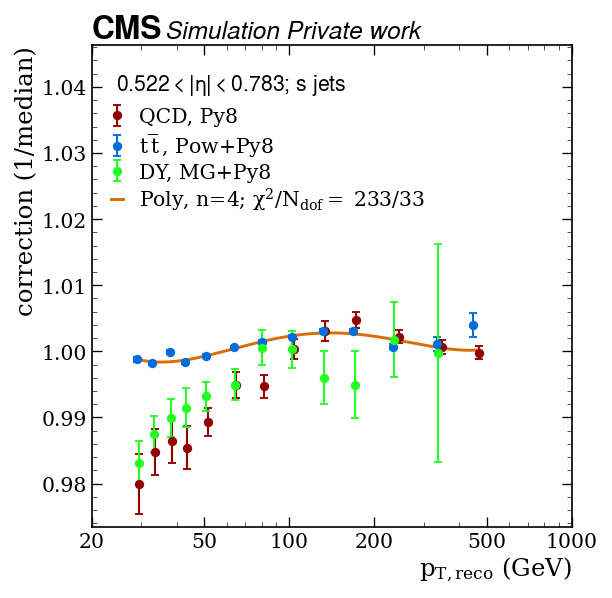

Fitting flavor:  s Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta0p783to1p044.pdf / .png


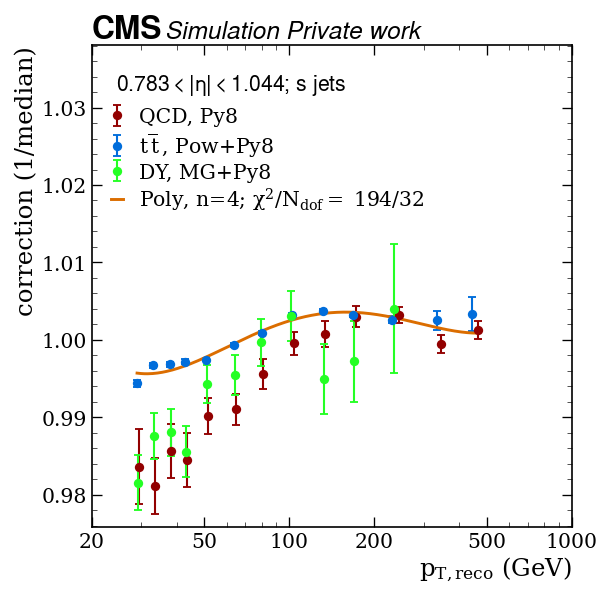

Fitting flavor:  s Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p044to1p305.pdf / .png


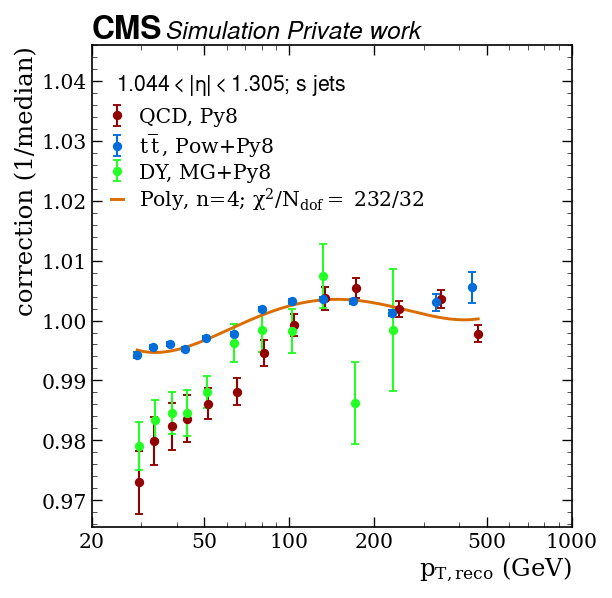

Fitting flavor:  s Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p305to1p566.pdf / .png


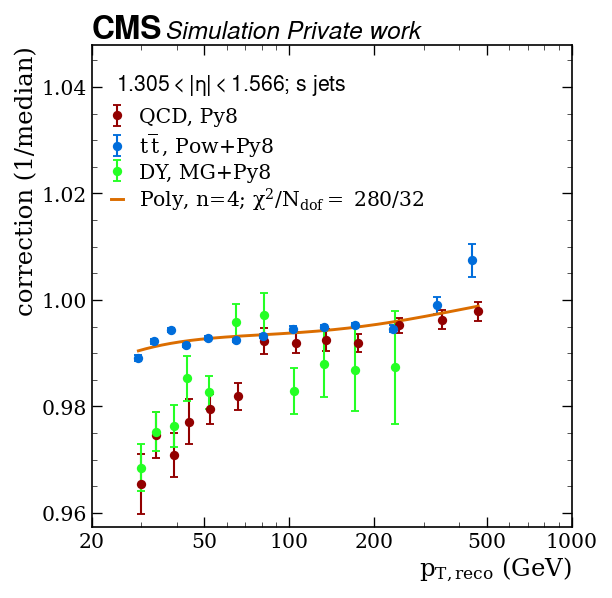

Fitting flavor:  s Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p566to1p74.pdf / .png


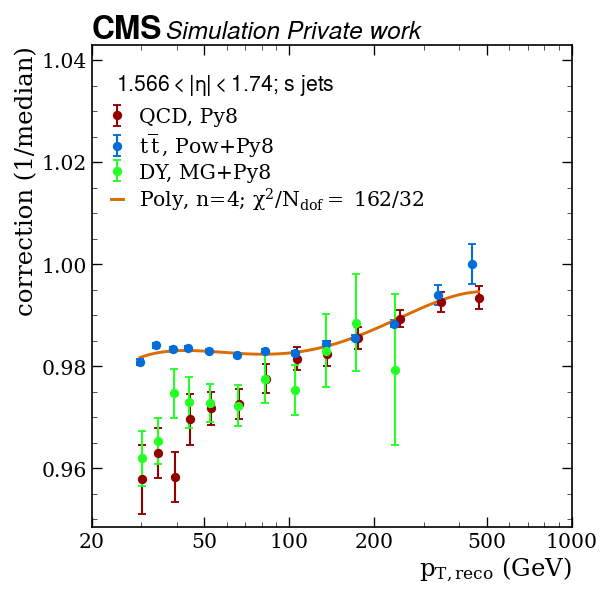

Fitting flavor:  s Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p74to1p93.pdf / .png


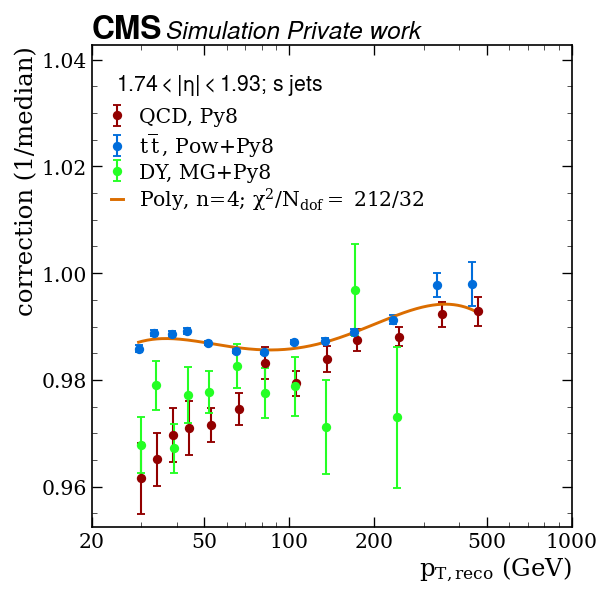

Fitting flavor:  s Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p93to2p043.pdf / .png


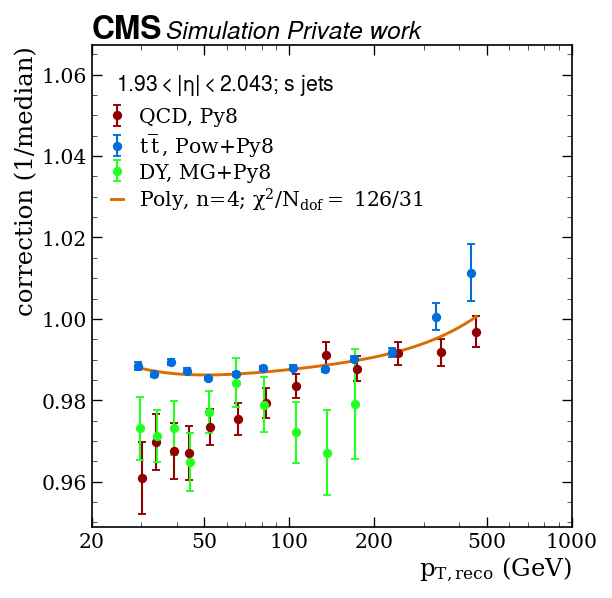

Fitting flavor:  s Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta2p043to2p172.pdf / .png


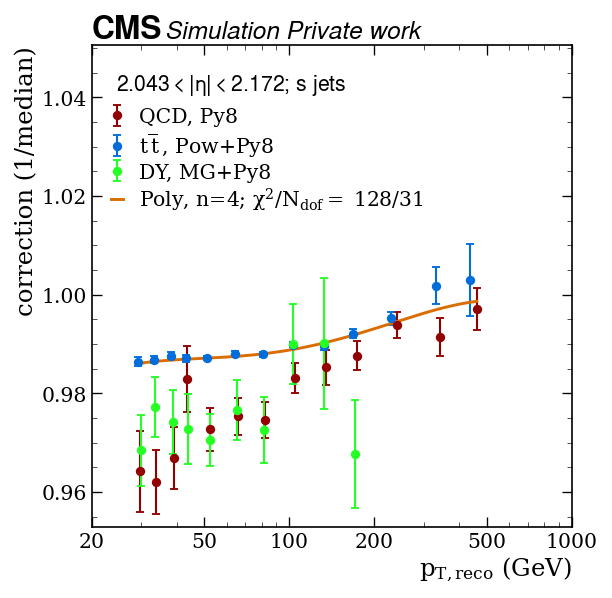

Fitting flavor:  s Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta2p172to2p5.pdf / .png


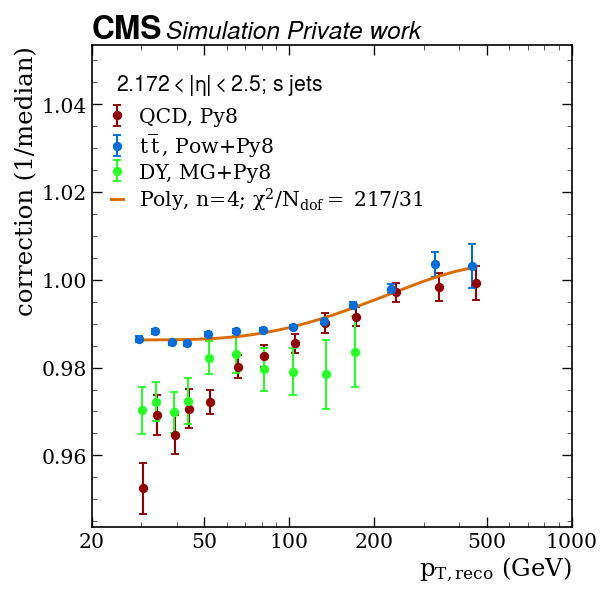

Fitting flavor:  s Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta2p5to2p964.pdf / .png


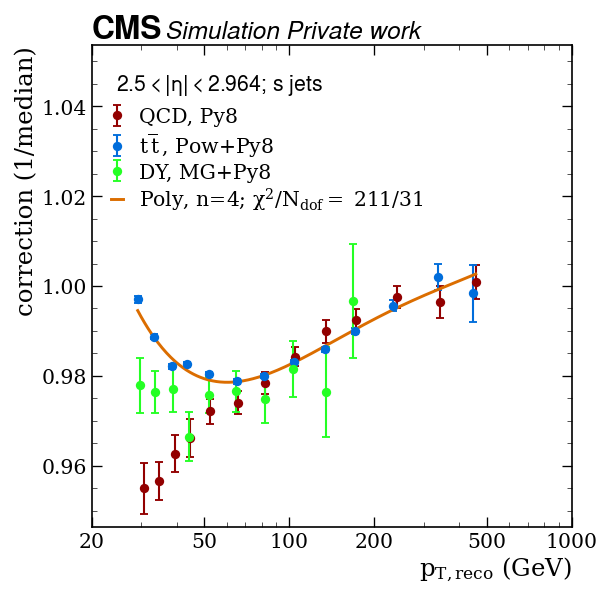

Fitting flavor:  s Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta2p964to5p191.pdf / .png


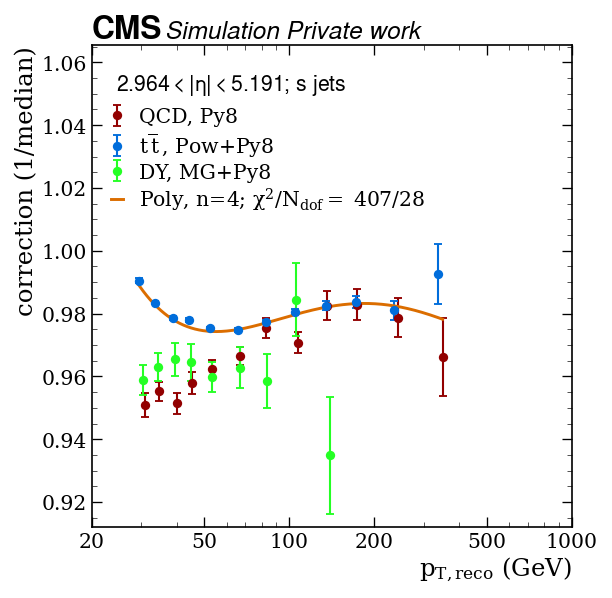

Fitting flavor:  ud Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta0p0to0p261.pdf / .png


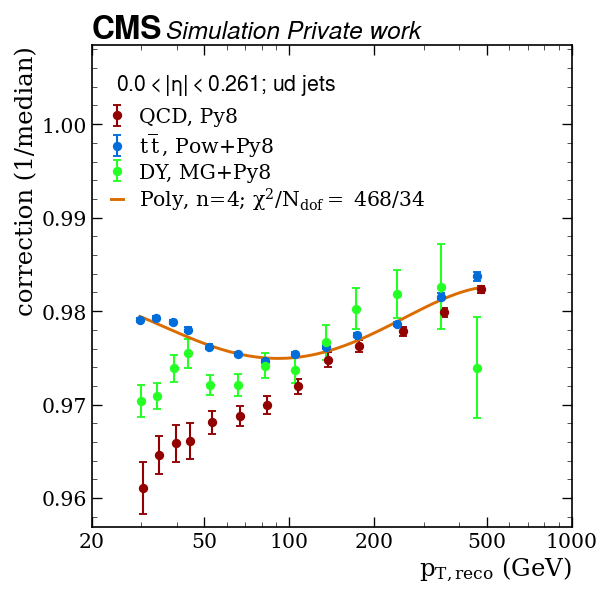

Fitting flavor:  ud Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta0p261to0p522.pdf / .png


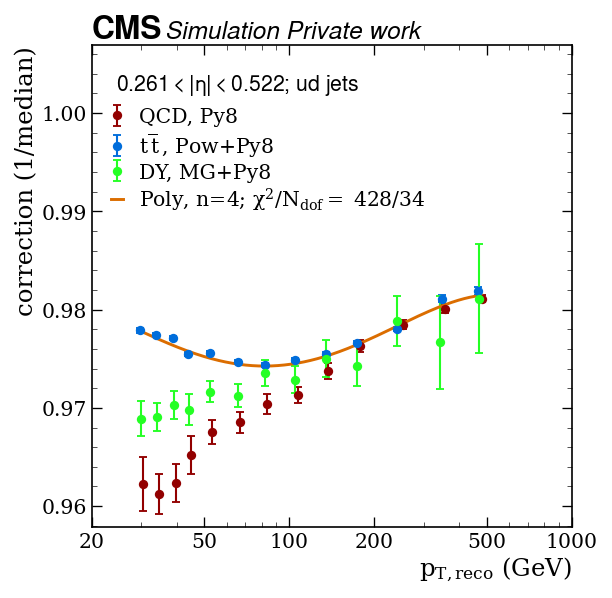

Fitting flavor:  ud Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta0p522to0p783.pdf / .png


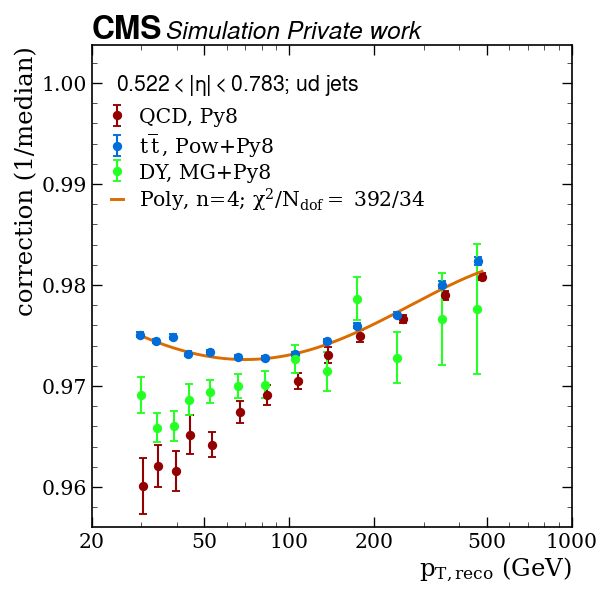

Fitting flavor:  ud Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta0p783to1p044.pdf / .png


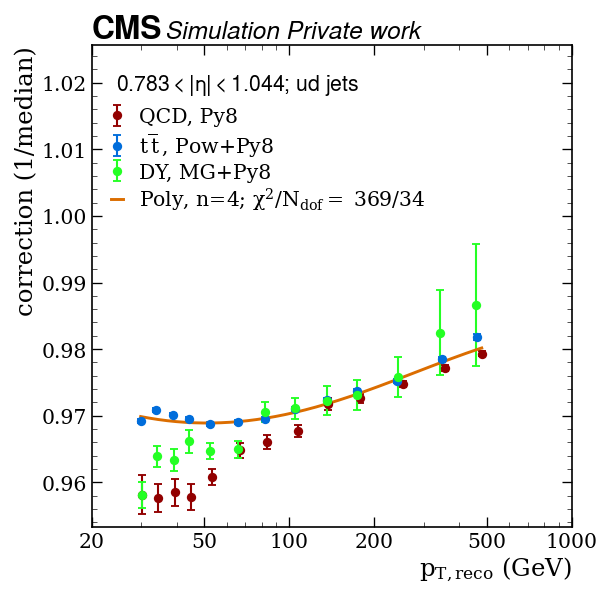

Fitting flavor:  ud Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p044to1p305.pdf / .png


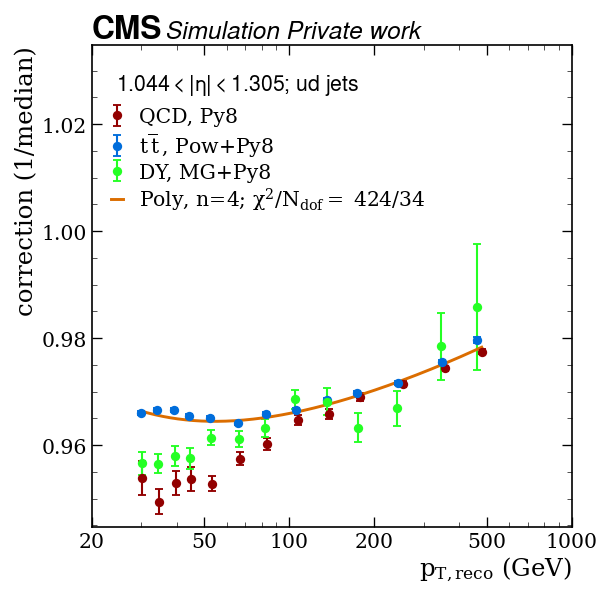

Fitting flavor:  ud Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p305to1p566.pdf / .png


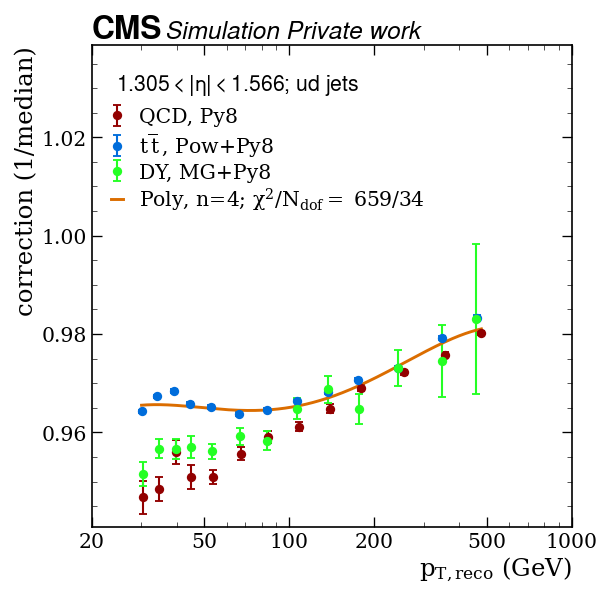

Fitting flavor:  ud Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p566to1p74.pdf / .png


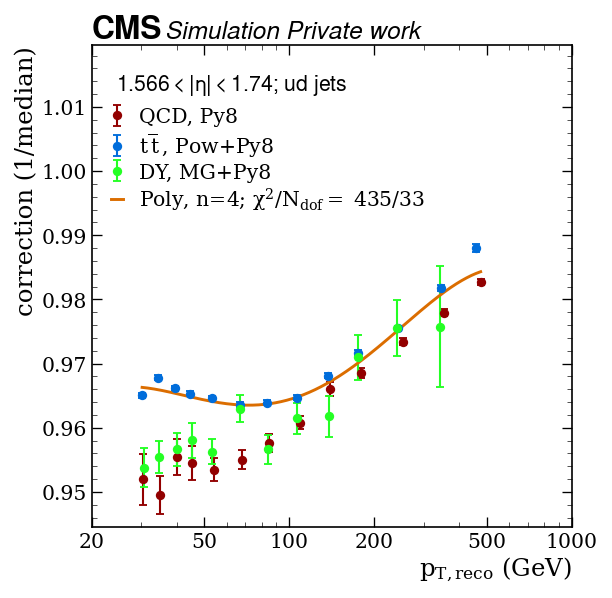

Fitting flavor:  ud Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p74to1p93.pdf / .png


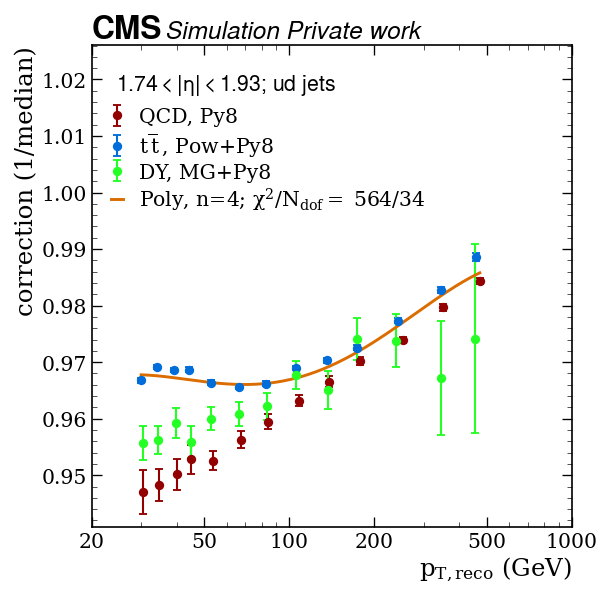

Fitting flavor:  ud Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p93to2p043.pdf / .png


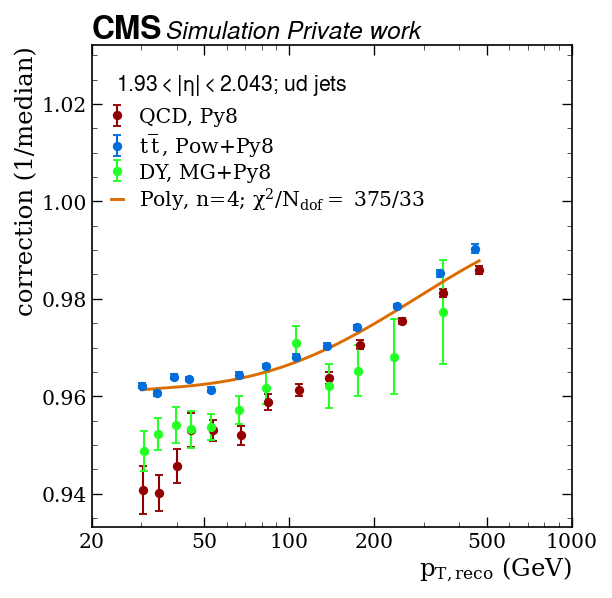

Fitting flavor:  ud Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta2p043to2p172.pdf / .png


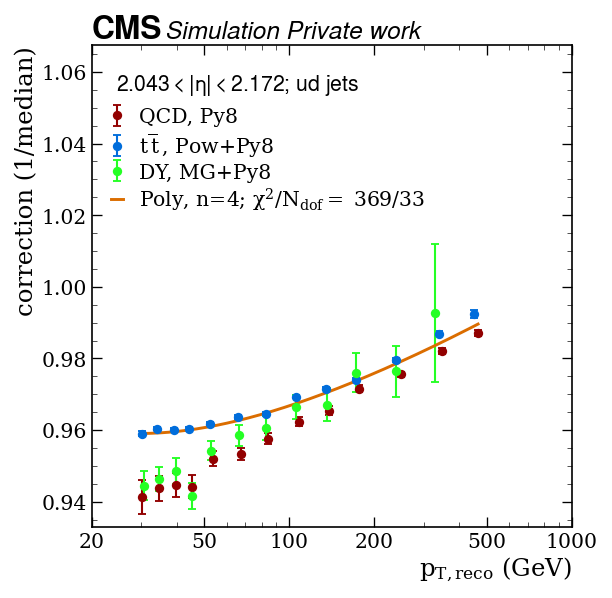

Fitting flavor:  ud Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta2p172to2p5.pdf / .png


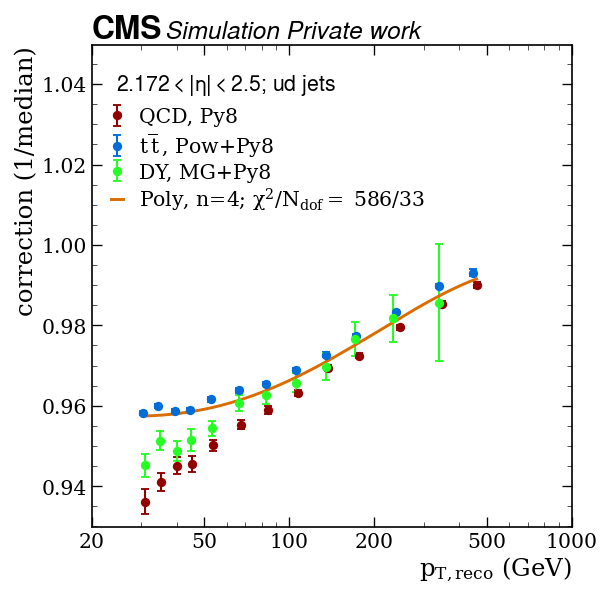

Fitting flavor:  ud Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta2p5to2p964.pdf / .png


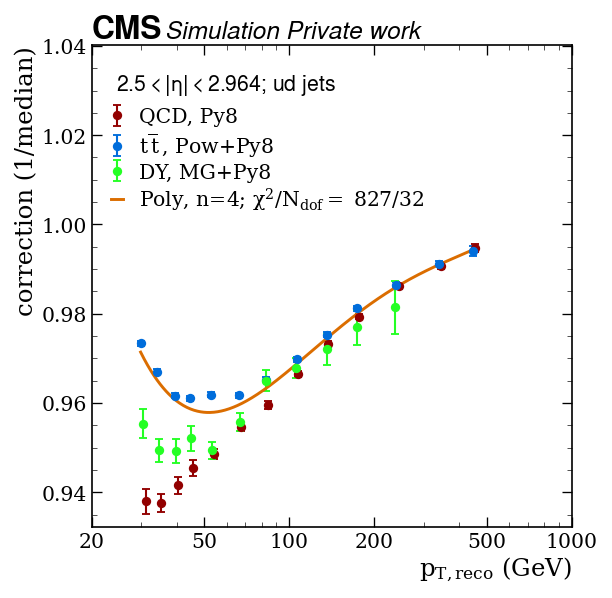

Fitting flavor:  ud Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta2p964to5p191.pdf / .png


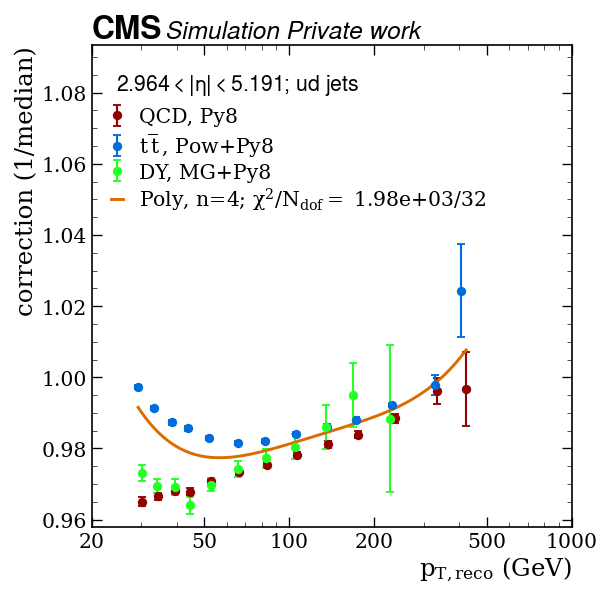

Fitting flavor:  q Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta0p0to0p261.pdf / .png


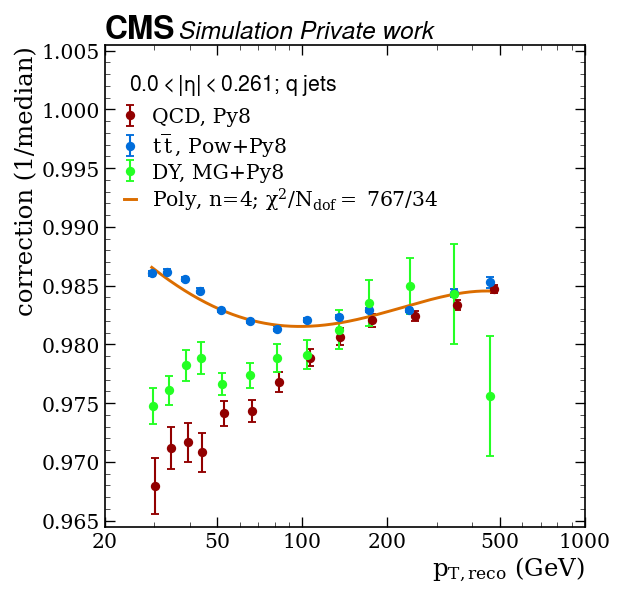

Fitting flavor:  q Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta0p261to0p522.pdf / .png


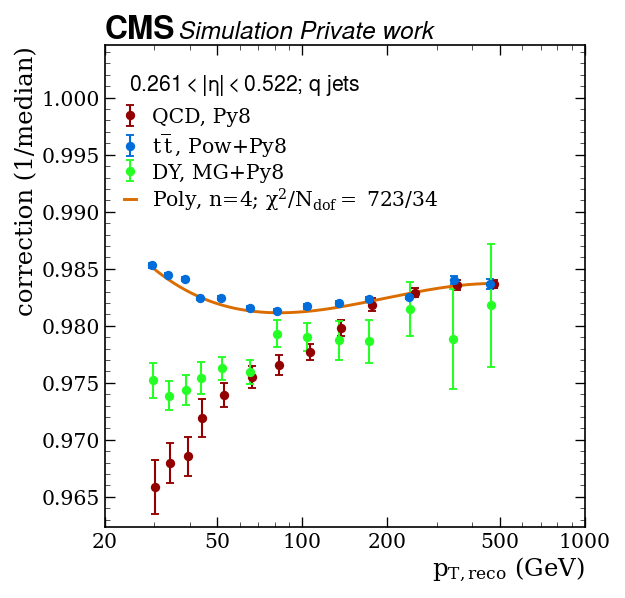

Fitting flavor:  q Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta0p522to0p783.pdf / .png


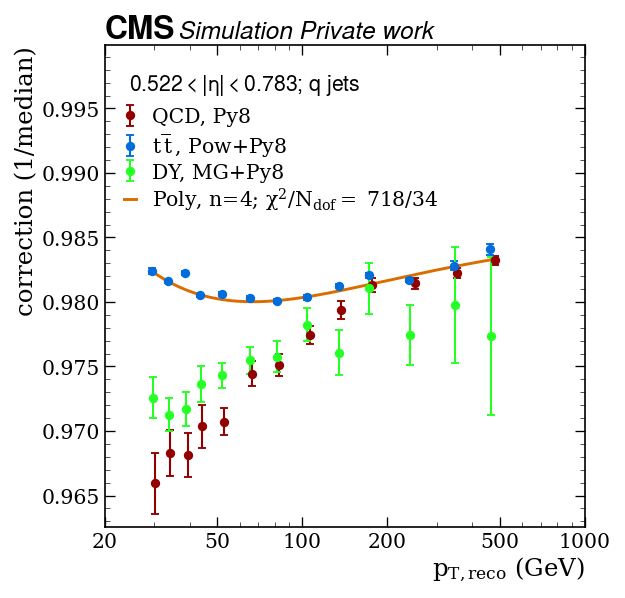

Fitting flavor:  q Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta0p783to1p044.pdf / .png


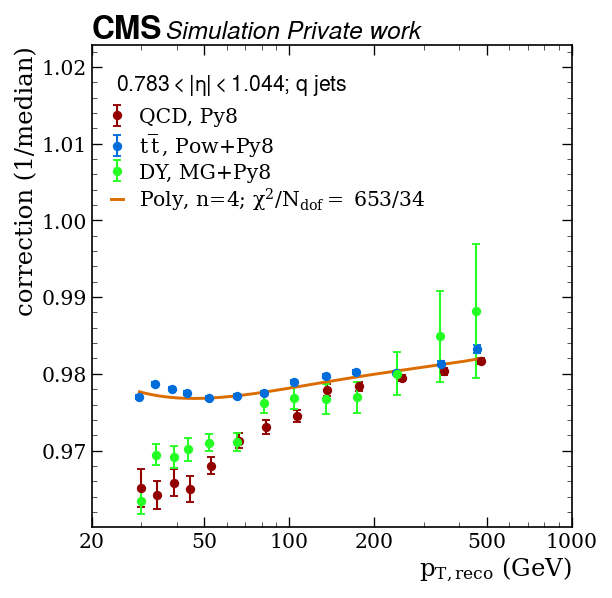

Fitting flavor:  q Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p044to1p305.pdf / .png


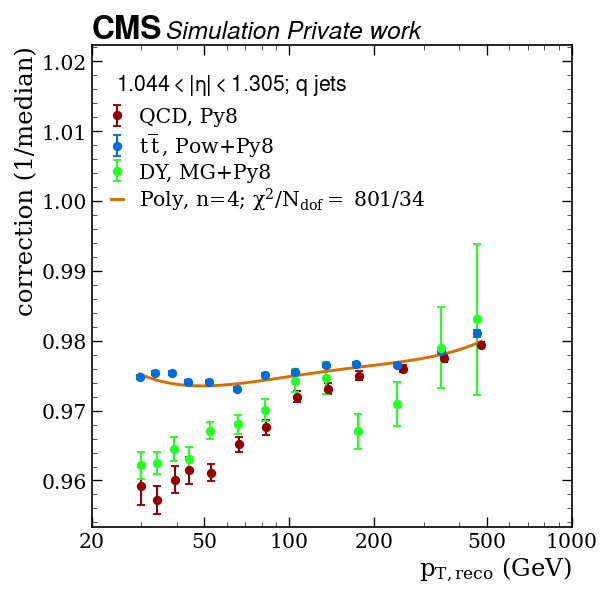

Fitting flavor:  q Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p305to1p566.pdf / .png


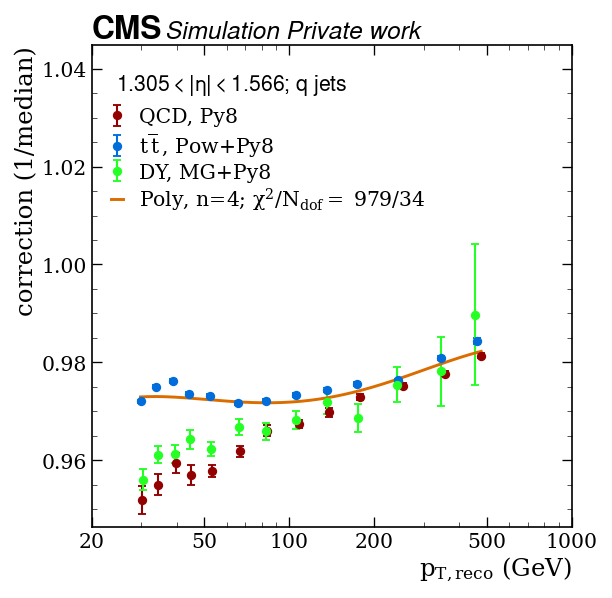

Fitting flavor:  q Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p566to1p74.pdf / .png


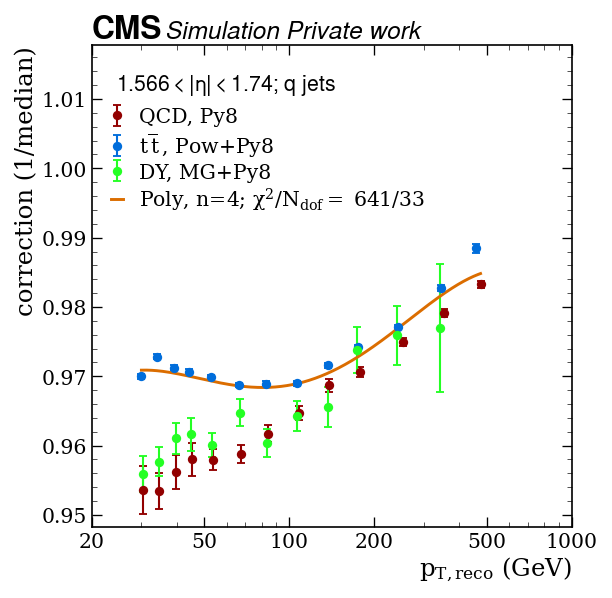

Fitting flavor:  q Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p74to1p93.pdf / .png


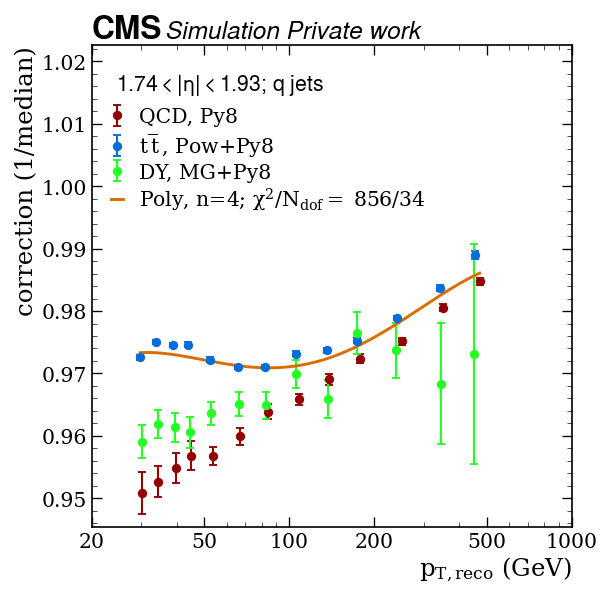

Fitting flavor:  q Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p93to2p043.pdf / .png


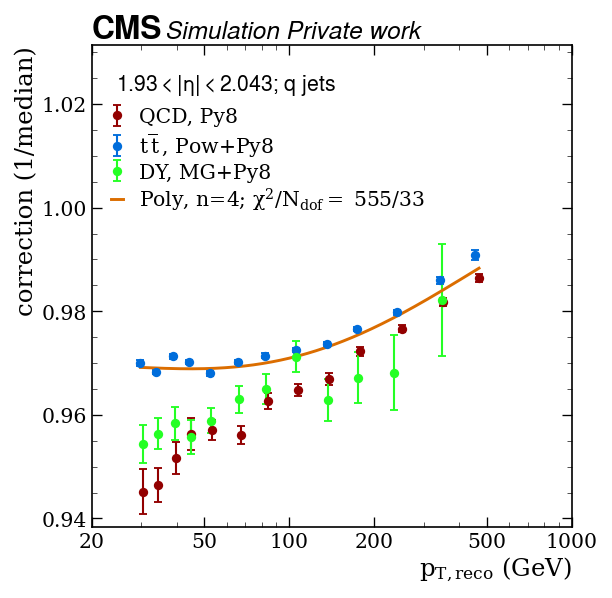

Fitting flavor:  q Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta2p043to2p172.pdf / .png


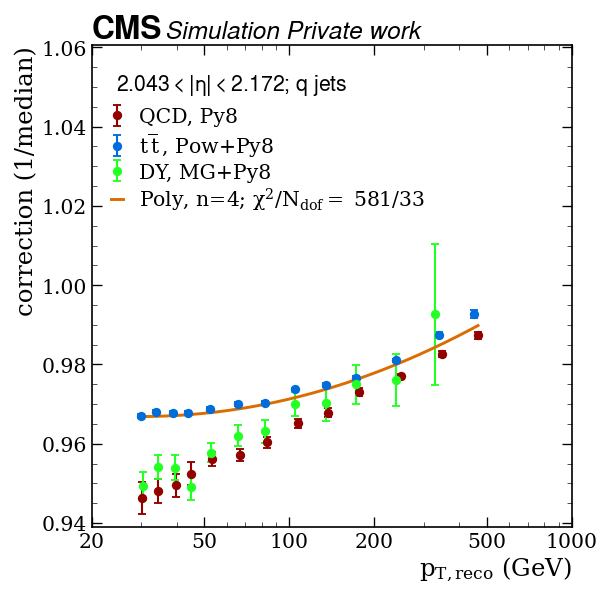

Fitting flavor:  q Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta2p172to2p5.pdf / .png


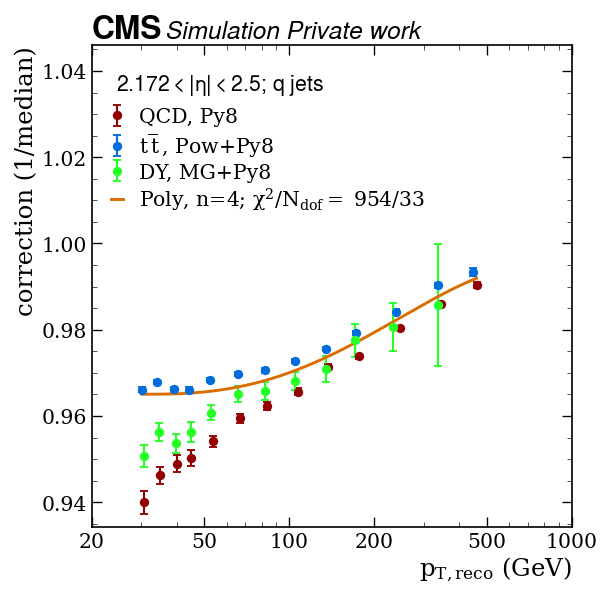

Fitting flavor:  q Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta2p5to2p964.pdf / .png


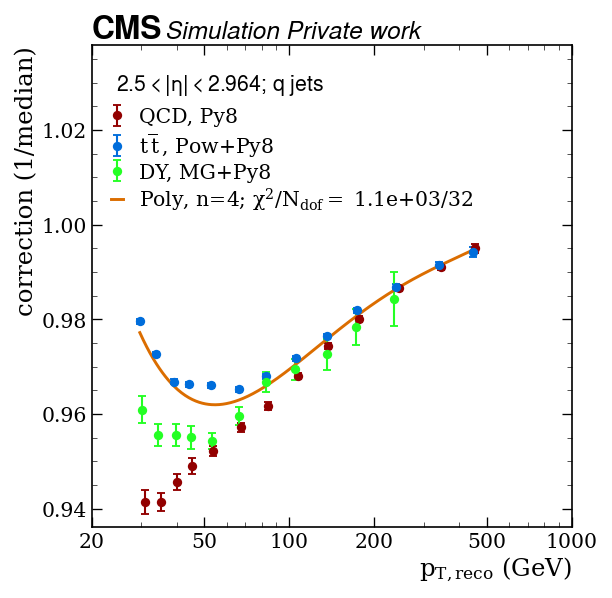

Fitting flavor:  q Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta2p964to5p191.pdf / .png


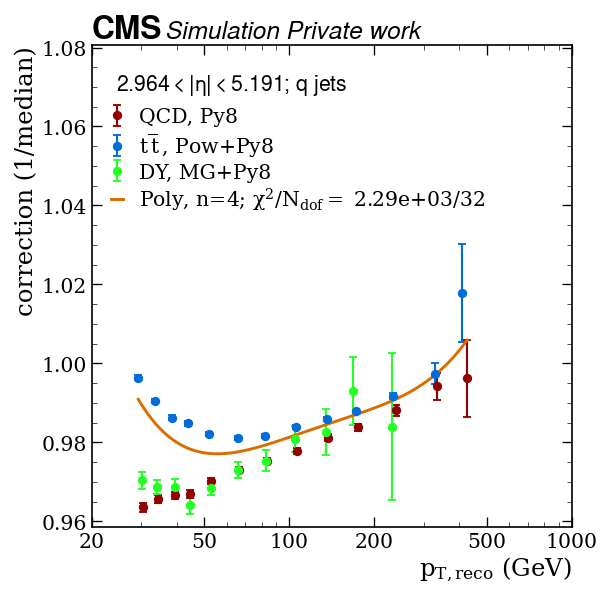

Fitting flavor:  unmatched Eta idx = 0, eta bin = [0.0; 0.261 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta0p0to0p261.pdf / .png


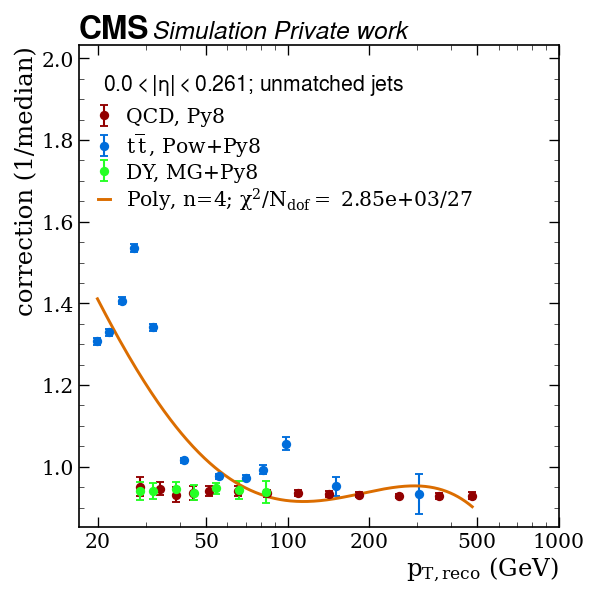

Fitting flavor:  unmatched Eta idx = 1, eta bin = [0.261; 0.522 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta0p261to0p522.pdf / .png


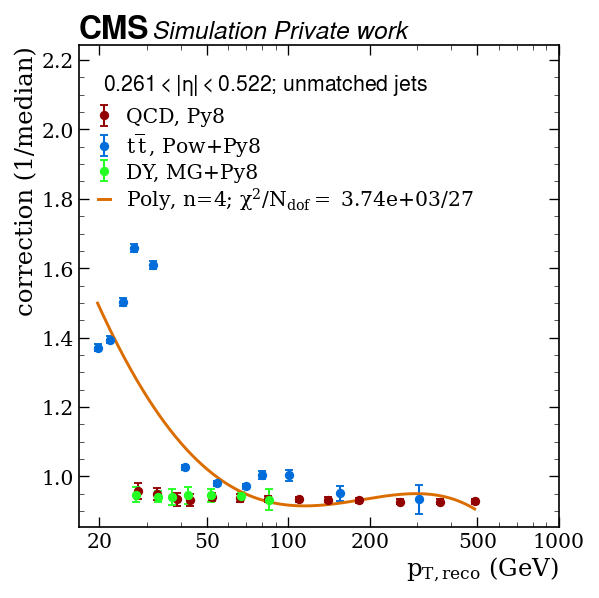

Fitting flavor:  unmatched Eta idx = 2, eta bin = [0.522; 0.783 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta0p522to0p783.pdf / .png


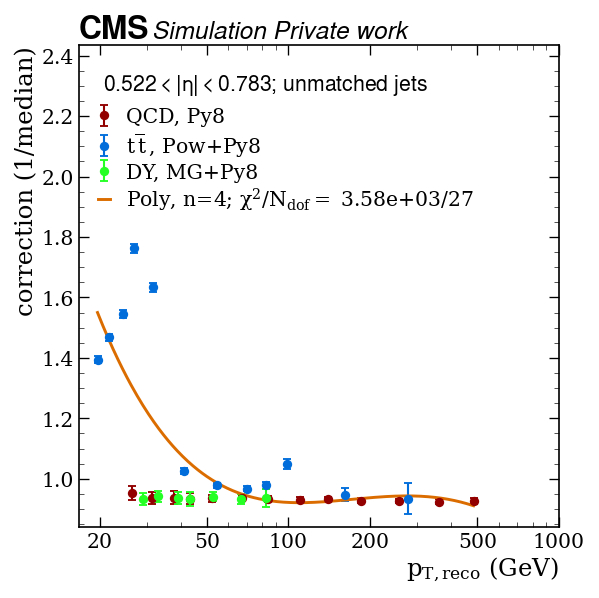

Fitting flavor:  unmatched Eta idx = 3, eta bin = [0.783; 1.044 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta0p783to1p044.pdf / .png


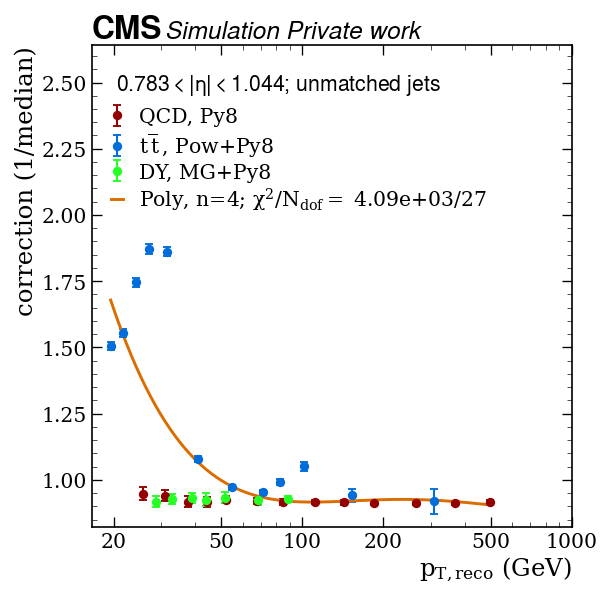

Fitting flavor:  unmatched Eta idx = 4, eta bin = [1.044; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p044to1p305.pdf / .png


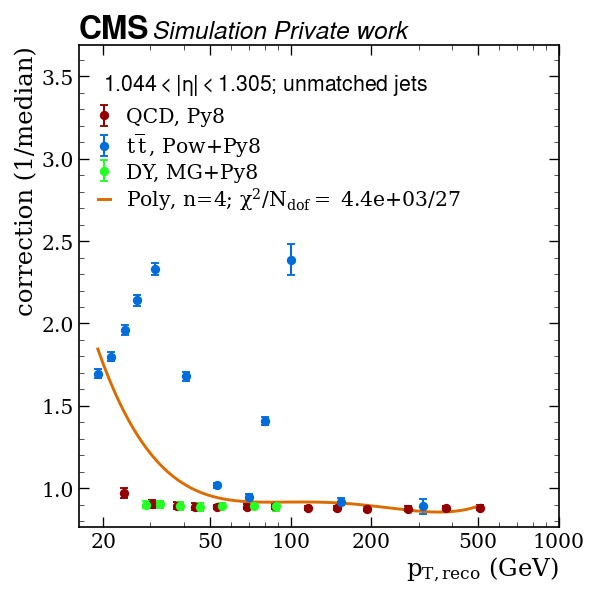

Fitting flavor:  unmatched Eta idx = 5, eta bin = [1.305; 1.566 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p305to1p566.pdf / .png


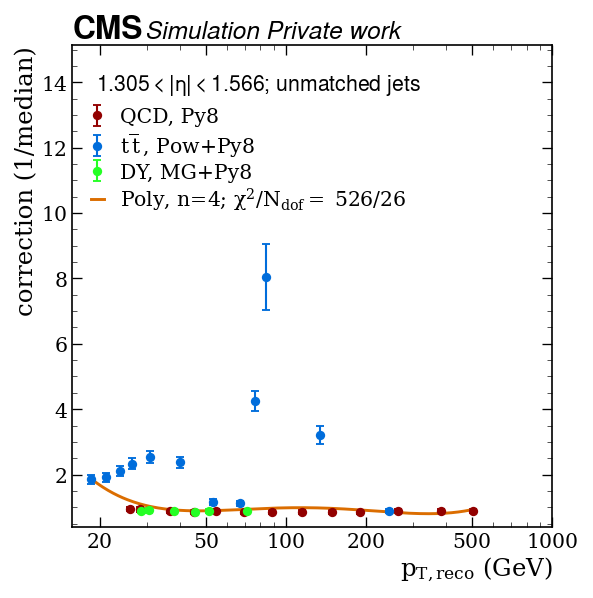

Fitting flavor:  unmatched Eta idx = 6, eta bin = [1.566; 1.74 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p566to1p74.pdf / .png


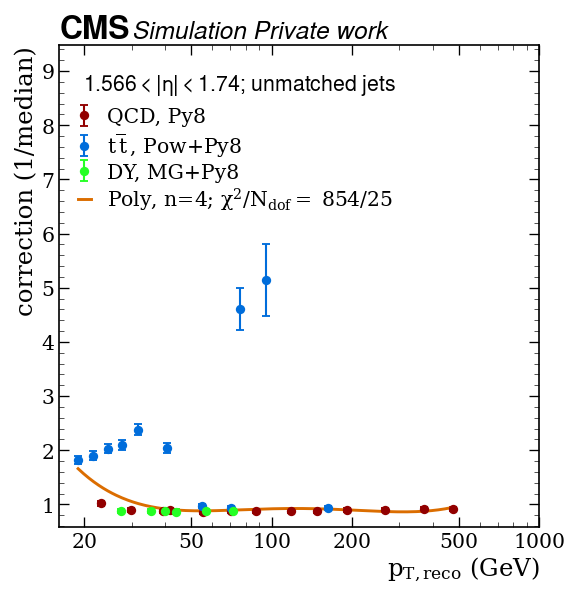

Fitting flavor:  unmatched Eta idx = 7, eta bin = [1.74; 1.93 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p74to1p93.pdf / .png


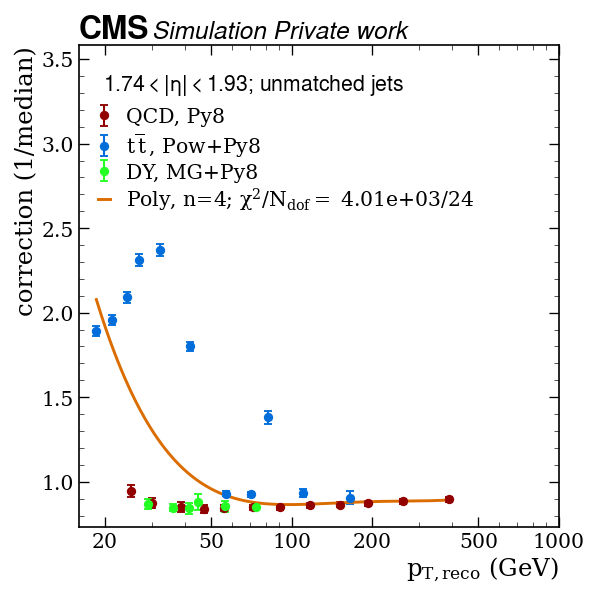

Fitting flavor:  unmatched Eta idx = 8, eta bin = [1.93; 2.043 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p93to2p043.pdf / .png


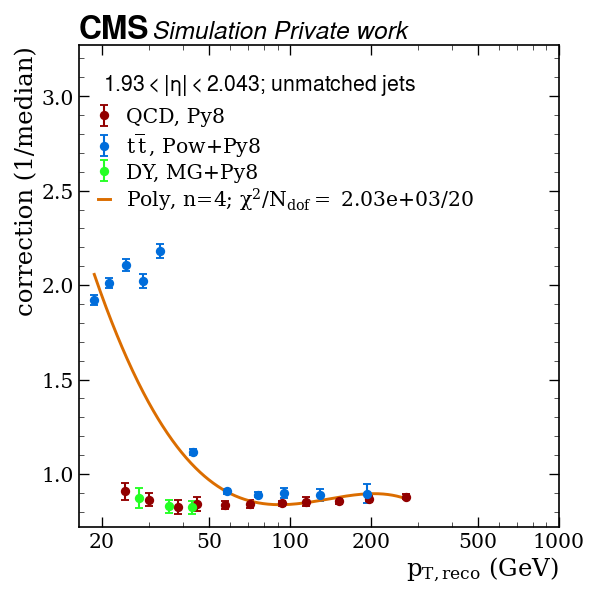

Fitting flavor:  unmatched Eta idx = 9, eta bin = [2.043; 2.172 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta2p043to2p172.pdf / .png


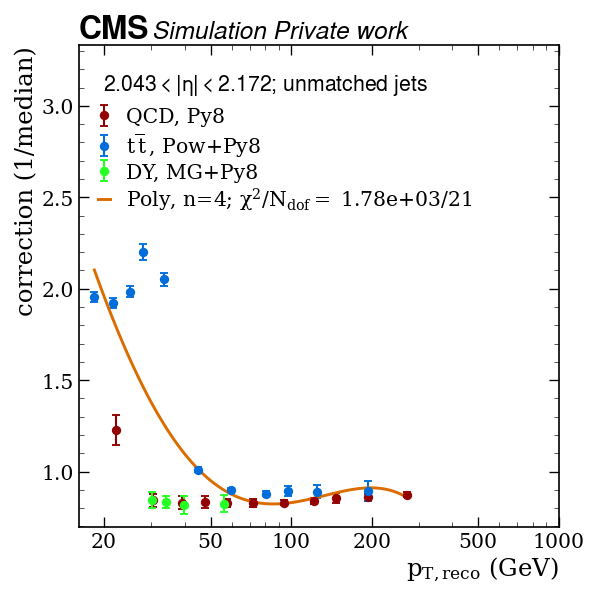

Fitting flavor:  unmatched Eta idx = 10, eta bin = [2.172; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta2p172to2p5.pdf / .png


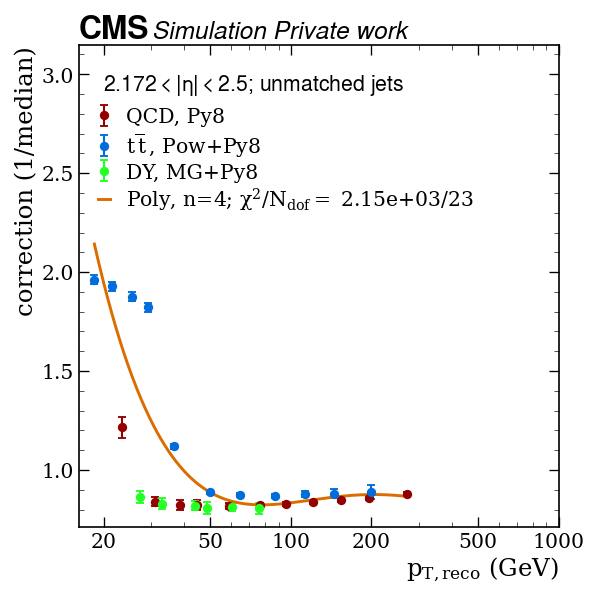

Fitting flavor:  unmatched Eta idx = 11, eta bin = [2.5; 2.964 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta2p5to2p964.pdf / .png


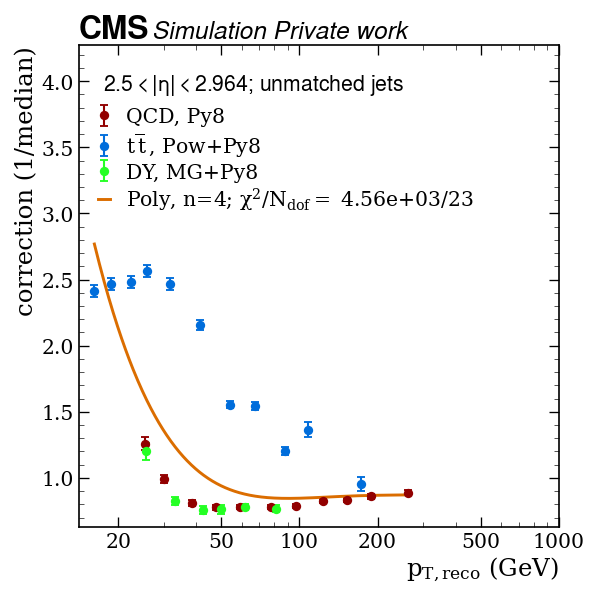

Fitting flavor:  unmatched Eta idx = 12, eta bin = [2.964; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta2p964to5p191.pdf / .png


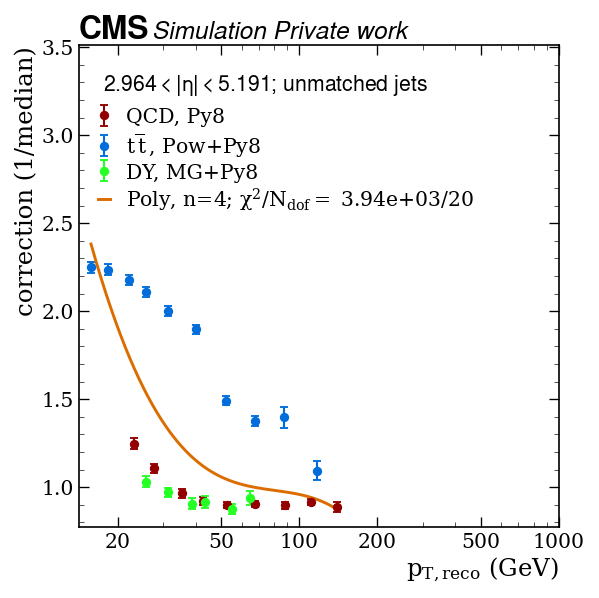

In [19]:
fits2plot = { ##name: [function, initial values, # parameters]
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
#              "Poly, n=3": [fits.poly3, [ 1, 1, 1, 1], 4],
             }

if not combine_antiflavour:
    flavors = ['bbar', 'b', 'c', 's', 'ud', 'cbar', 'sbar', 'udbar']
else:
    flavors = ['b', 'c', 'u', 'd', 'g', 's', 'ud', 'q', 'unmatched'] #, 'all'
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.0005
min_rel_uncert_relative = 0.01
# tags, names = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8", 'DY, MG+Py8']
# tags, names = ['_L5_QCD-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, Py8', f"{ttbarlab}, Pow+Py8", 'DY, MG+Py8']
tags, names = ['_L5_QCD-Py_wrongdr', '_L5_Pythia-semilep-TTBAR_wrongdr', '_L5_DY-MG-Py_wrongdr'], ['QCD, Py8', f"{ttbarlab}, Pow+Py8", 'DY, MG+Py8']

# tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR', '_L5_DY-MG-Her'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7", 'DY, MG+Her7']

# tags, names = ['_L5_Pythia-TTBAR', '_L5_QCD-MG-Py'], [f"{ttbarlab} Pow+Py8", 'QCD, MG+Py8']
tags = [tag+eta_binning_str+combine_antiflavour_txt for tag in tags]

# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit{combine_antiflavour_txt}_Her{eta_binning_str}.txt'
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit_Her{combine_antiflavour_txt+eta_binning_str}.txt'
txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePy_simfit{combine_antiflavour_txt}QCD{eta_binning_str}.txt'

# closure = read_data("Median", "all", '_L5_QCD-MG-Py'+eta_binning_str)
closure = read_data("Median", "all", '_L5_QCD-Py_wrongdr'+eta_binning_str)

fit_res_all = {}

for flav in flavors:
    fit_res = []
    if not combine_antiflavour:
        flav2 = flav[:-3] if 'bar' in flav else flav
        closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
    data = {tag: read_data4plot(flav, tag, closure ) for tag in tags}

    for etaidx in range(jeteta_bins.nbins):
        init_vals_Winter14 = [0]*6

        print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
        fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                              fits2plot=fits2plot, main_fit="Poly, n=4",
                              figdir2=figdir,
                              jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                              plot_initial_val=False,
                              use_recopt=True,
                              maxlimit_static_pnt=False,
                              min_rel_uncert_relative=min_rel_uncert_relative,
                              show_original_errorbars=False)
        
        fit_res = np.concatenate([fit_res, fit_res_new])

    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
    correction_name = my_mapping(flav)+'J'
    fit_res_all[correction_name] = fit_res

'a';

In [36]:
fits.save_correction_txt_file(txtfile_outname, {"simfit":fit_res_all})

Saving the corrections with the name =  Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePy_simfitQCD_Summer20Flavor.txt


In [ ]:
# # txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                
# print("Saving the corrections with the name = ", txtfile_outname)
# 4; ## to suppress printouts of write

### Fit median responses in a specific bin interactivelly with ip widgets

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
# interact(response_fnc_raw, x=2, p0=10);

In [ ]:
# # [data, meanstd, recopt]
# def fit_corrections_for_interact(samp, etabin, p0=1, p1=1, p2=1, p3=1, p4=1, p5=1, plot_initial_val=False):
#     data = read_data("Median", samp)[:,etabin]
#     data[data==0] = np.nan
#     mean = (1/data) #*closure[:,etabin]
#     meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
#     reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
#     fit_corrections(samp, etabin, [data, meanstd, recopt], init_vals_Winter14=np.array([p0, p1, p2, p3, p4, p5]), plot_initial_val=plot_initial_val)

In [ ]:
# all_subsamples = ['b', 'c', 'u', 'd', 'g', 's', 'all']

# import ipywidgets as widgets

# sub = widgets.Dropdown(
#     options=all_subsamples,
#     value='b',
#     description='Subsample:',
#     disabled=False,
# )

# etabin = widgets.Dropdown(
#     options=[0,1,2,3,4],
#     value=0,
#     description='Subsample:',
#     disabled=False,
# )

# print(init_vals_2014[sub.value][etabin.value])

# p0 = widgets.FloatSlider(value=7.5, min=0, max=10.0, step=0.1,
#                          description='p0', continuous_update=True, 
#                         )
# p1 = widgets.FloatSlider(value=13.8495, min=0, max=20.0, step=0.1, description='p2', continuous_update=True,
#                         )

# p2 = widgets.FloatSlider(
#     value=17.8549,
#     min=0,
#     max=20.0,
#     step=0.1,
#     description='p2',
#     continuous_update=True,
# )

# p3 = widgets.FloatSlider(
#     value=-0.215711,
#     min=-10.0,
#     max=10.0,
#     step=0.1,
#     description='p3',
#     continuous_update=True,
# )

# p4 = widgets.FloatSlider(
#     value=0.576285,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p4',
#     continuous_update=True,
# )

# p5 = widgets.FloatSlider(
#     value=1.42258,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p5',
#     continuous_update=True,
# )



# display(sub, etabin, p0, p1, p2, p3, p4, p5)

# # [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]

In [ ]:
# a = widgets.IntSlider(description="Delayed", continuous_update=False)
# b = widgets.IntText(description="Delayed", continuous_update=False)
# c = widgets.IntSlider(description="Continuous", continuous_update=True)
# d = widgets.IntText(description="Continuous", continuous_update=True)

# widgets.link((a, 'value'), (b, 'value'))
# widgets.link((a, 'value'), (c, 'value'))
# widgets.link((a, 'value'), (d, 'value'))
# widgets.VBox([a,b,c,d])

In [ ]:
# the_interaction = interactive(fit_corrections_for_interact, samp=all_subsamples, etabin=(0,3,1), p0=(-2,2,0.01), p1=(-200,200,0.1),
#                p2=(-10,300,0.1), p3=(-50,10,0.5), p4=(-1,10,0.1), p5=(-3,3,0.1), plot_initial_val=True ) 

# output2 = widgets.Output()

# for widg in the_interaction.children[:-1]:
# #     if "p" in widg.description:
#     widg.continuous_update = False

# samp_inter = the_interaction.children[0]
# eta_inter = the_interaction.children[1]
# pt_inter = the_interaction.children[2:8]
# # pt_inter = init_vals_2014[samp_inter.value][eta_inter.value]
# for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
#     ptii.value = init_val
    
# def redefine_initial_vals_eta(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][change['new']['value']]):
# #         [pt_inter[0].value, pt_inter[1].value] = init_vals_2014[samp_inter.value][change['new']['value']][:1]
#             ptii.value = init_val
            
# def redefine_initial_vals_sample(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[change['new']['value']][eta_inter.value]):
#             ptii.value = init_val
# #         pt_inter[0].value = init_vals_2014[samp_inter.value][change['new']['value']][0]
# #     for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
# #     ptii.value = init_val
    
# eta_inter.observe(redefine_initial_vals_eta)
    
# display(the_interaction)

In [ ]:
# fig, ax = plt.subplots()
# ax.plot([1,2,3,4,5], [1,4,5,7,8], label='bla', linewidth=1.1, markersize=0);

In [ ]:
print('-----'*10)
print("All done. Congrats!")